
# Introduction #

Welcome to the [**Petals to the Metal**](https://www.kaggle.com/c/tpu-getting-started) competition! In this competition, you’re challenged to build a machine learning model to classify 104 types of flowers based on their images.

In this tutorial notebook, you'll learn how to build an image classifier in Keras and train it on a [Tensor Processing Unit (TPU)](https://www.kaggle.com/docs/tpu). At the end, you'll have a complete project you can build off of with ideas of your own.

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
    <strong>Fork This Notebook!</strong><br>
Create your own editable copy of this notebook by clicking on the <strong>Copy and Edit</strong> button in the top right corner.
</blockquote>

# Step 1: Imports #

We begin by importing several Python packages.

In [1]:
import math, re, os
import numpy as np
import tensorflow as tf

print("Tensorflow version " + tf.__version__)

E0000 00:00:1756217879.032722      74 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


Tensorflow version 2.18.0


# Step 2: Distribution Strategy #

A TPU has eight different *cores* and each of these cores acts as its own accelerator. (A TPU is sort of like having eight GPUs in one machine.) We tell TensorFlow how to make use of all these cores at once through a **distribution strategy**. Run the following cell to create the distribution strategy that we'll later apply to our model.

In [2]:
# Detect TPU, return appropriate distribution strategy
try:
    # tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    # strategy = tf.distribute.experimental.TPUStrategy(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1756217902.195386      74 service.cc:148] XLA service 0x58b009250f60 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756217902.195425      74 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1756217902.195429      74 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1756217902.195433      74 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1756217902.195435      74 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1756217902.195438      74 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1756217902.195441      74 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1756217902.195443      74 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8


I0000 00:00:1756217902.195446      74 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


We'll use the distribution strategy when we create our neural network model. Then, TensorFlow will distribute the training among the eight TPU cores by creating eight different *replicas* of the model, one for each core.

# Step 3: Loading the Competition Data #

## Get GCS Path ##

When used with TPUs, datasets need to be stored in a [Google Cloud Storage bucket](https://cloud.google.com/storage/). You can use data from any public GCS bucket by giving its path just like you would data from `'/kaggle/input'`. The following will retrieve the GCS path for this competition's dataset.

In [3]:
from kaggle_datasets import KaggleDatasets

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(GCS_DS_PATH) # what do gcs paths look like?

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/tpu-getting-started


/kaggle/input/tpu-getting-started


You can use data from any public dataset here on Kaggle in just the same way. If you'd like to use data from one of your private datasets, see [here](https://www.kaggle.com/docs/tpu#tpu3pt5).

## Load Data ##

When used with TPUs, datasets are often serialized into [TFRecords](https://www.kaggle.com/ryanholbrook/tfrecords-basics). This is a format convenient for distributing data to each of the TPUs cores. We've hidden the cell that reads the TFRecords for our dataset since the process is a bit long. You could come back to it later for some guidance on using your own datasets with TPUs.

In [4]:

IMAGE_SIZE = [512, 512]
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-512x512'
AUTO = tf.data.experimental.AUTOTUNE

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    # image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

## Create Data Pipelines ##

In this final step we'll use the `tf.data` API to define an efficient data pipeline for each of the training, validation, and test splits.

In [5]:

def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO)
    # statement in the next function (below), this happens essentially
    # for free on TPU. Data pipeline code is executed on the "CPU"
    # part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))


Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


This next cell will create the datasets that we'll use with Keras during training and inference. Notice how we scale the size of the batches to the number of TPU cores.

In [6]:
# Define the batch size. This will be 16 with TPU off and 128 (=16*8) with TPU on
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Training: <_PrefetchDataset element_spec=(TensorSpec(shape=(128, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128,), dtype=tf.int32, name=None))>
Validation: <_PrefetchDataset element_spec=(TensorSpec(shape=(128, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128,), dtype=tf.int32, name=None))>
Test: <_PrefetchDataset element_spec=(TensorSpec(shape=(128, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128,), dtype=tf.string, name=None))>


These datasets are `tf.data.Dataset` objects. You can think about a dataset in TensorFlow as a *stream* of data records. The training and validation sets are streams of `(image, label)` pairs.

In [7]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:


(128, 512, 512, 3) (128,)


(128, 512, 512, 3) (128,)


(128, 512, 512, 3) (128,)


Training data label examples: [103  68  78 ...  91  69  70]


The test set is a stream of `(image, idnum)` pairs; `idnum` here is the unique identifier given to the image that we'll use later when we make our submission as a `csv` file.

In [8]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Test data shapes:


(128, 512, 512, 3) (128,)


(128, 512, 512, 3) (128,)


(128, 512, 512, 3) (128,)


Test data IDs: ['e58b03040' 'a2b499115' '19e95658b' ... '524961d31' 'ce71e2dfe' 'fac9307e4']


# Step 4: Explore Data #

Let's take a moment to look at some of the images in the dataset.

In [9]:

from matplotlib import pyplot as plt

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.figure(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

You can display a single batch of images from a dataset with another of our helper functions. The next cell will turn the dataset into an iterator of batches of 20 images.

In [10]:
ds_iter = iter(ds_train.unbatch().batch(20))

Use the Python `next` function to pop out the next batch in the stream and display it with the helper function.

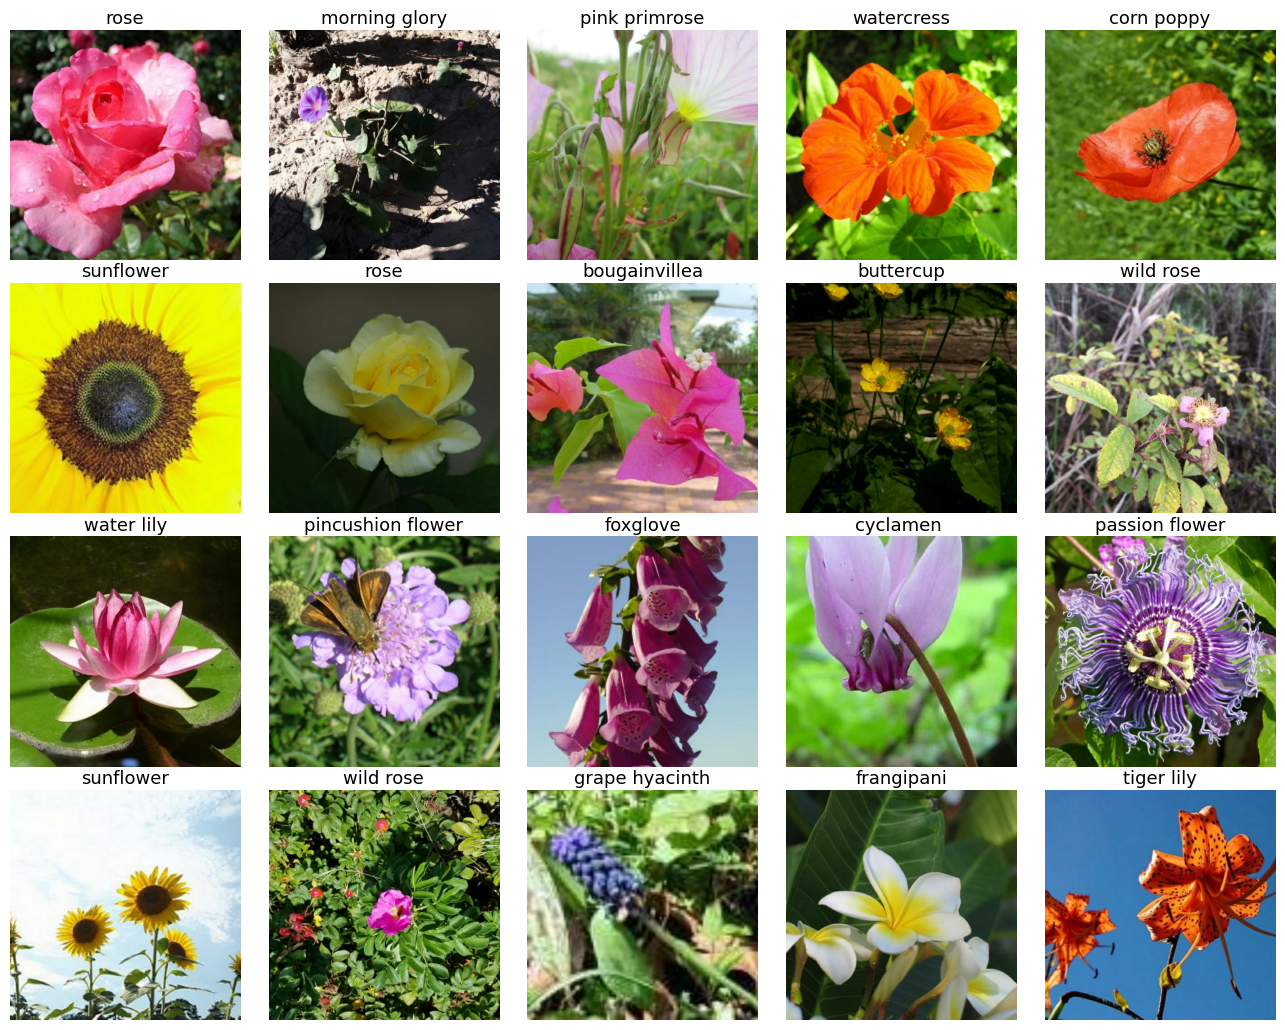

In [11]:
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

By defining `ds_iter` and `one_batch` in separate cells, you only need to rerun the cell above to see a new batch of images.

# Step 5: Define Model #

Now we're ready to create a neural network for classifying images! We'll use what's known as **transfer learning**. With transfer learning, you reuse part of a pretrained model to get a head-start on a new dataset.

For this tutorial, we'll to use a model called **VGG16** pretrained on [ImageNet](http://image-net.org/)). Later, you might want to experiment with [other models](https://www.tensorflow.org/api_docs/python/tf/keras/applications) included with Keras. ([Xception](https://www.tensorflow.org/api_docs/python/tf/keras/applications/Xception) wouldn't be a bad choice.)

The distribution strategy we created earlier contains a [context manager](https://docs.python.org/3/reference/compound_stmts.html#with), `strategy.scope`. This context manager tells TensorFlow how to divide the work of training among the eight TPU cores. When using TensorFlow with a TPU, it's important to define your model in a `strategy.scope()` context.

In [12]:
EPOCHS = 12

with strategy.scope():
    pretrained_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False
    
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

I0000 00:00:1756217915.499925      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


       0/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

   49152/58889256 ━━━━━━━━━━━━━━━━━━━━ 2:14 2us/step

   81920/58889256 ━━━━━━━━━━━━━━━━━━━━ 2:29 3us/step

  147456/58889256 ━━━━━━━━━━━━━━━━━━━━ 1:43 2us/step

  212992/58889256 ━━━━━━━━━━━━━━━━━━━━ 1:25 1us/step

  294912/58889256 ━━━━━━━━━━━━━━━━━━━━ 1:12 1us/step

  442368/58889256 ━━━━━━━━━━━━━━━━━━━━ 54s 1us/step 

  638976/58889256 ━━━━━━━━━━━━━━━━━━━━ 42s 1us/step

  901120/58889256 ━━━━━━━━━━━━━━━━━━━━ 33s 1us/step

 1327104/58889256 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step

 1933312/58889256 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step

 2850816/58889256 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step

 4177920/58889256 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step 

 6119424/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 8044544/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

10608640/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

13221888/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

15712256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

18259968/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

20815872/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

23379968/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

25911296/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

28524544/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

31006720/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

33579008/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

36208640/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

38666240/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

41213952/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

43786240/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

46333952/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

48881664/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

51421184/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

53968896/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

56532992/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


The `'sparse_categorical'` versions of the loss and metrics are appropriate for a classification task with more than two labels, like this one.

In [13]:
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 16, 16, 512)    │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 104)            │        53,352 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,768,040 (56.34 MB)

 Trainable params: 53,352 (208.41 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Step 6: Training #

## Learning Rate Schedule ##

We'll train this network with a special learning rate schedule.

Learning rate schedule: 1e-05 to 5e-05 to 2.05e-05


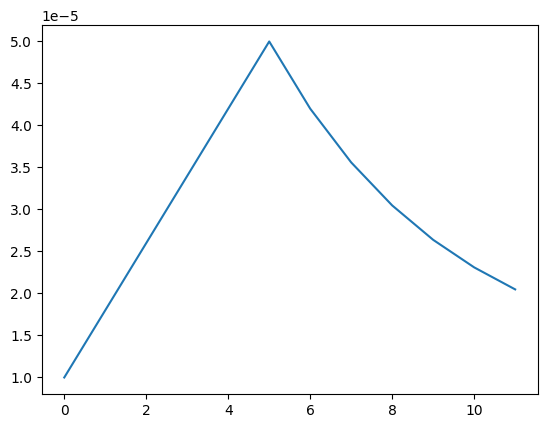

In [14]:

# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## Fit Model ##

And now we're ready to train the model. After defining a few parameters, we're good to go!

In [15]:
# Define training epochs
EPOCHS = 12
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

with strategy.scope():
    pretrained_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False
    
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

    model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
    )

    history = model.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[lr_callback],
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.


Epoch 1/12


I0000 00:00:1756217929.800395      74 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:13869558048848221098


I0000 00:00:1756217929.947428     896 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(10422597616708843969), session_name()


I0000 00:00:1756217938.967720     896 tpu_compile_op_common.cc:245] Compilation of 10422597616708843969 with session name  took 9.020216107s and succeeded


I0000 00:00:1756217938.972699     896 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(10422597616708843969), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_13869558048848221098", property.function_library_fingerprint = 7728875747193571605, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1756217938.972734     896 tpu_compilation_cache_interface.cc:542] After adding entry for key 10422597616708843969 with session_name  cache is 1 entries (12856918 bytes),  marked for eviction 0 entries (0 bytes).


 1/99 ━━━━━━━━━━━━━━━━━━━━ 17:02 10s/step - loss: 4.9417 - sparse_categorical_accuracy: 0.0000e+00

 2/99 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - loss: 4.8766 - sparse_categorical_accuracy: 0.0000e+00

 3/99 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - loss: 4.8533 - sparse_categorical_accuracy: 0.0000e+00

 4/99 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - loss: 4.8298 - sparse_categorical_accuracy: 0.0000e+00

 5/99 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - loss: 4.8135 - sparse_categorical_accuracy: 0.0000e+00

 6/99 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step - loss: 4.7949 - sparse_categorical_accuracy: 0.0000e+00

 7/99 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - loss: 4.7817 - sparse_categorical_accuracy: 0.0000e+00

 8/99 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step - loss: 4.7703 - sparse_categorical_accuracy: 9.7656e-04

 9/99 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - loss: 4.7587 - sparse_categorical_accuracy: 0.0016    

10/99 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - loss: 4.7498 - sparse_categorical_accuracy: 0.0027

11/99 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step - loss: 4.7399 - sparse_categorical_accuracy: 0.0040

12/99 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - loss: 4.7294 - sparse_categorical_accuracy: 0.0054

13/99 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - loss: 4.7179 - sparse_categorical_accuracy: 0.0072

14/99 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - loss: 4.7061 - sparse_categorical_accuracy: 0.0089

15/99 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - loss: 4.6945 - sparse_categorical_accuracy: 0.0103

16/99 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - loss: 4.6836 - sparse_categorical_accuracy: 0.0116

17/99 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - loss: 4.6731 - sparse_categorical_accuracy: 0.0129

18/99 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - loss: 4.6632 - sparse_categorical_accuracy: 0.0141

19/99 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step - loss: 4.6538 - sparse_categorical_accuracy: 0.0151

20/99 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 4.6450 - sparse_categorical_accuracy: 0.0159

21/99 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - loss: 4.6369 - sparse_categorical_accuracy: 0.0165

22/99 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - loss: 4.6286 - sparse_categorical_accuracy: 0.0173

23/99 ━━━━━━━━━━━━━━━━━━━━ 13s 181ms/step - loss: 4.6203 - sparse_categorical_accuracy: 0.0181

24/99 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - loss: 4.6120 - sparse_categorical_accuracy: 0.0192

25/99 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - loss: 4.6036 - sparse_categorical_accuracy: 0.0203

26/99 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - loss: 4.5956 - sparse_categorical_accuracy: 0.0213

27/99 ━━━━━━━━━━━━━━━━━━━━ 12s 179ms/step - loss: 4.5879 - sparse_categorical_accuracy: 0.0222

28/99 ━━━━━━━━━━━━━━━━━━━━ 12s 176ms/step - loss: 4.5802 - sparse_categorical_accuracy: 0.0231

29/99 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - loss: 4.5726 - sparse_categorical_accuracy: 0.0241

30/99 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - loss: 4.5655 - sparse_categorical_accuracy: 0.0250

31/99 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - loss: 4.5587 - sparse_categorical_accuracy: 0.0258

32/99 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 4.5518 - sparse_categorical_accuracy: 0.0267

33/99 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 4.5452 - sparse_categorical_accuracy: 0.0275

34/99 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 4.5385 - sparse_categorical_accuracy: 0.0286

35/99 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 4.5321 - sparse_categorical_accuracy: 0.0296

36/99 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 4.5258 - sparse_categorical_accuracy: 0.0306

37/99 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 4.5201 - sparse_categorical_accuracy: 0.0315

38/99 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - loss: 4.5146 - sparse_categorical_accuracy: 0.0323

39/99 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - loss: 4.5092 - sparse_categorical_accuracy: 0.0331

40/99 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - loss: 4.5038 - sparse_categorical_accuracy: 0.0338

41/99 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - loss: 4.4987 - sparse_categorical_accuracy: 0.0345

42/99 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - loss: 4.4933 - sparse_categorical_accuracy: 0.0353

43/99 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - loss: 4.4881 - sparse_categorical_accuracy: 0.0360 

44/99 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 4.4830 - sparse_categorical_accuracy: 0.0367

45/99 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 4.4781 - sparse_categorical_accuracy: 0.0374

46/99 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 4.4734 - sparse_categorical_accuracy: 0.0381

47/99 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - loss: 4.4690 - sparse_categorical_accuracy: 0.0388

48/99 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 4.4644 - sparse_categorical_accuracy: 0.0396

49/99 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - loss: 4.4598 - sparse_categorical_accuracy: 0.0402

50/99 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - loss: 4.4555 - sparse_categorical_accuracy: 0.0409

51/99 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - loss: 4.4512 - sparse_categorical_accuracy: 0.0415

52/99 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - loss: 4.4472 - sparse_categorical_accuracy: 0.0421

53/99 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - loss: 4.4433 - sparse_categorical_accuracy: 0.0427

54/99 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - loss: 4.4395 - sparse_categorical_accuracy: 0.0434

55/99 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 4.4356 - sparse_categorical_accuracy: 0.0440

56/99 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - loss: 4.4318 - sparse_categorical_accuracy: 0.0446

57/99 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 4.4282 - sparse_categorical_accuracy: 0.0452

58/99 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - loss: 4.4245 - sparse_categorical_accuracy: 0.0458

59/99 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - loss: 4.4210 - sparse_categorical_accuracy: 0.0464

60/99 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - loss: 4.4176 - sparse_categorical_accuracy: 0.0469

61/99 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - loss: 4.4141 - sparse_categorical_accuracy: 0.0475

62/99 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - loss: 4.4107 - sparse_categorical_accuracy: 0.0481

63/99 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - loss: 4.4074 - sparse_categorical_accuracy: 0.0486

64/99 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - loss: 4.4039 - sparse_categorical_accuracy: 0.0492

65/99 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - loss: 4.4006 - sparse_categorical_accuracy: 0.0498

66/99 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - loss: 4.3974 - sparse_categorical_accuracy: 0.0504

67/99 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 4.3942 - sparse_categorical_accuracy: 0.0510

68/99 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - loss: 4.3910 - sparse_categorical_accuracy: 0.0515

69/99 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 4.3879 - sparse_categorical_accuracy: 0.0521

70/99 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 4.3846 - sparse_categorical_accuracy: 0.0526

71/99 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 4.3814 - sparse_categorical_accuracy: 0.0532

72/99 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - loss: 4.3782 - sparse_categorical_accuracy: 0.0538

73/99 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 4.3750 - sparse_categorical_accuracy: 0.0544

74/99 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - loss: 4.3719 - sparse_categorical_accuracy: 0.0550

75/99 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - loss: 4.3689 - sparse_categorical_accuracy: 0.0555

76/99 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - loss: 4.3659 - sparse_categorical_accuracy: 0.0561

77/99 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - loss: 4.3628 - sparse_categorical_accuracy: 0.0566

78/99 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - loss: 4.3599 - sparse_categorical_accuracy: 0.0572

79/99 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - loss: 4.3569 - sparse_categorical_accuracy: 0.0577

80/99 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - loss: 4.3541 - sparse_categorical_accuracy: 0.0583

81/99 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - loss: 4.3513 - sparse_categorical_accuracy: 0.0588

82/99 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - loss: 4.3485 - sparse_categorical_accuracy: 0.0593

83/99 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 4.3458 - sparse_categorical_accuracy: 0.0598

84/99 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 4.3431 - sparse_categorical_accuracy: 0.0603

85/99 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 4.3404 - sparse_categorical_accuracy: 0.0608

86/99 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 4.3377 - sparse_categorical_accuracy: 0.0613

87/99 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 4.3351 - sparse_categorical_accuracy: 0.0617

88/99 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 4.3325 - sparse_categorical_accuracy: 0.0622

89/99 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 4.3299 - sparse_categorical_accuracy: 0.0626

90/99 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 4.3274 - sparse_categorical_accuracy: 0.0631

91/99 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 4.3249 - sparse_categorical_accuracy: 0.0635

92/99 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 4.3224 - sparse_categorical_accuracy: 0.0640

93/99 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 4.3199 - sparse_categorical_accuracy: 0.0644

94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 4.3174 - sparse_categorical_accuracy: 0.0648

95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 4.3150 - sparse_categorical_accuracy: 0.0652

96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 4.3127 - sparse_categorical_accuracy: 0.0656

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 4.3103 - sparse_categorical_accuracy: 0.0660

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 4.3080 - sparse_categorical_accuracy: 0.0663

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 4.3056 - sparse_categorical_accuracy: 0.0667

I0000 00:00:1756217960.482982      74 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:16780700569192434260


I0000 00:00:1756217960.574949     858 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(6852272982595344273), session_name()


I0000 00:00:1756217967.023157     858 tpu_compile_op_common.cc:245] Compilation of 6852272982595344273 with session name  took 6.448155926s and succeeded


I0000 00:00:1756217967.025958     858 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(6852272982595344273), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_16780700569192434260", property.function_library_fingerprint = 8944292218986187613, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1756217967.025989     858 tpu_compilation_cache_interface.cc:542] After adding entry for key 6852272982595344273 with session_name  cache is 2 entries (24788268 bytes),  marked for eviction 0 entries (0 bytes).


/usr/local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


99/99 ━━━━━━━━━━━━━━━━━━━━ 42s 323ms/step - loss: 4.3036 - sparse_categorical_accuracy: 0.0670 - val_loss: 3.8829 - val_sparse_categorical_accuracy: 0.1379 - learning_rate: 0.0010



Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.


Epoch 2/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 3.7955 - sparse_categorical_accuracy: 0.2500

 2/99 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - loss: 3.9043 - sparse_categorical_accuracy: 0.2031

 3/99 ━━━━━━━━━━━━━━━━━━━━ 23s 244ms/step - loss: 3.9775 - sparse_categorical_accuracy: 0.1701

 4/99 ━━━━━━━━━━━━━━━━━━━━ 20s 213ms/step - loss: 3.9851 - sparse_categorical_accuracy: 0.1549

 5/99 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - loss: 3.9797 - sparse_categorical_accuracy: 0.1515

 6/99 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step - loss: 3.9652 - sparse_categorical_accuracy: 0.1505

 7/99 ━━━━━━━━━━━━━━━━━━━━ 18s 205ms/step - loss: 3.9516 - sparse_categorical_accuracy: 0.1494

 8/99 ━━━━━━━━━━━━━━━━━━━━ 17s 189ms/step - loss: 3.9477 - sparse_categorical_accuracy: 0.1493

 9/99 ━━━━━━━━━━━━━━━━━━━━ 17s 196ms/step - loss: 3.9468 - sparse_categorical_accuracy: 0.1481

10/99 ━━━━━━━━━━━━━━━━━━━━ 16s 185ms/step - loss: 3.9448 - sparse_categorical_accuracy: 0.1471

11/99 ━━━━━━━━━━━━━━━━━━━━ 16s 191ms/step - loss: 3.9423 - sparse_categorical_accuracy: 0.1461

12/99 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - loss: 3.9383 - sparse_categorical_accuracy: 0.1452

13/99 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - loss: 3.9345 - sparse_categorical_accuracy: 0.1448

14/99 ━━━━━━━━━━━━━━━━━━━━ 15s 181ms/step - loss: 3.9320 - sparse_categorical_accuracy: 0.1446

15/99 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - loss: 3.9306 - sparse_categorical_accuracy: 0.1447

16/99 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - loss: 3.9286 - sparse_categorical_accuracy: 0.1449

17/99 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - loss: 3.9268 - sparse_categorical_accuracy: 0.1455

18/99 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 3.9251 - sparse_categorical_accuracy: 0.1465

19/99 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - loss: 3.9232 - sparse_categorical_accuracy: 0.1480

20/99 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - loss: 3.9212 - sparse_categorical_accuracy: 0.1495

21/99 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - loss: 3.9189 - sparse_categorical_accuracy: 0.1508

22/99 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - loss: 3.9162 - sparse_categorical_accuracy: 0.1524

23/99 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - loss: 3.9135 - sparse_categorical_accuracy: 0.1537

24/99 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - loss: 3.9118 - sparse_categorical_accuracy: 0.1546

25/99 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - loss: 3.9103 - sparse_categorical_accuracy: 0.1556

26/99 ━━━━━━━━━━━━━━━━━━━━ 12s 176ms/step - loss: 3.9086 - sparse_categorical_accuracy: 0.1563

27/99 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - loss: 3.9076 - sparse_categorical_accuracy: 0.1569

28/99 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - loss: 3.9065 - sparse_categorical_accuracy: 0.1573

29/99 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - loss: 3.9052 - sparse_categorical_accuracy: 0.1579

30/99 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - loss: 3.9038 - sparse_categorical_accuracy: 0.1584

31/99 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 3.9021 - sparse_categorical_accuracy: 0.1589

32/99 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 3.9004 - sparse_categorical_accuracy: 0.1593

33/99 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 3.8985 - sparse_categorical_accuracy: 0.1597

34/99 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 3.8966 - sparse_categorical_accuracy: 0.1600

35/99 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 3.8946 - sparse_categorical_accuracy: 0.1605

36/99 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 3.8928 - sparse_categorical_accuracy: 0.1608

37/99 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - loss: 3.8909 - sparse_categorical_accuracy: 0.1613

38/99 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - loss: 3.8888 - sparse_categorical_accuracy: 0.1617

39/99 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - loss: 3.8868 - sparse_categorical_accuracy: 0.1620

40/99 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - loss: 3.8850 - sparse_categorical_accuracy: 0.1623

41/99 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - loss: 3.8831 - sparse_categorical_accuracy: 0.1627

42/99 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - loss: 3.8815 - sparse_categorical_accuracy: 0.1630

43/99 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - loss: 3.8800 - sparse_categorical_accuracy: 0.1632 

44/99 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - loss: 3.8786 - sparse_categorical_accuracy: 0.1635

45/99 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - loss: 3.8774 - sparse_categorical_accuracy: 0.1637

46/99 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - loss: 3.8762 - sparse_categorical_accuracy: 0.1639

47/99 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - loss: 3.8753 - sparse_categorical_accuracy: 0.1640

48/99 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - loss: 3.8742 - sparse_categorical_accuracy: 0.1643

49/99 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - loss: 3.8732 - sparse_categorical_accuracy: 0.1644

50/99 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - loss: 3.8722 - sparse_categorical_accuracy: 0.1646

51/99 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - loss: 3.8713 - sparse_categorical_accuracy: 0.1647

52/99 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - loss: 3.8703 - sparse_categorical_accuracy: 0.1648

53/99 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - loss: 3.8695 - sparse_categorical_accuracy: 0.1649

54/99 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 3.8685 - sparse_categorical_accuracy: 0.1650

55/99 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - loss: 3.8674 - sparse_categorical_accuracy: 0.1652

56/99 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - loss: 3.8662 - sparse_categorical_accuracy: 0.1654

57/99 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - loss: 3.8651 - sparse_categorical_accuracy: 0.1656

58/99 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 3.8640 - sparse_categorical_accuracy: 0.1658

59/99 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - loss: 3.8629 - sparse_categorical_accuracy: 0.1660

60/99 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - loss: 3.8618 - sparse_categorical_accuracy: 0.1662

61/99 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - loss: 3.8608 - sparse_categorical_accuracy: 0.1663

62/99 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - loss: 3.8597 - sparse_categorical_accuracy: 0.1665

63/99 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - loss: 3.8588 - sparse_categorical_accuracy: 0.1667

64/99 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - loss: 3.8577 - sparse_categorical_accuracy: 0.1669

65/99 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - loss: 3.8566 - sparse_categorical_accuracy: 0.1671

66/99 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - loss: 3.8556 - sparse_categorical_accuracy: 0.1672

67/99 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - loss: 3.8547 - sparse_categorical_accuracy: 0.1674

68/99 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - loss: 3.8537 - sparse_categorical_accuracy: 0.1675

69/99 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - loss: 3.8528 - sparse_categorical_accuracy: 0.1676

70/99 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - loss: 3.8519 - sparse_categorical_accuracy: 0.1678

71/99 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - loss: 3.8510 - sparse_categorical_accuracy: 0.1679

72/99 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - loss: 3.8503 - sparse_categorical_accuracy: 0.1680

73/99 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - loss: 3.8496 - sparse_categorical_accuracy: 0.1681

74/99 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - loss: 3.8488 - sparse_categorical_accuracy: 0.1682

75/99 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - loss: 3.8479 - sparse_categorical_accuracy: 0.1683

76/99 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - loss: 3.8472 - sparse_categorical_accuracy: 0.1684

77/99 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 3.8465 - sparse_categorical_accuracy: 0.1685

78/99 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - loss: 3.8457 - sparse_categorical_accuracy: 0.1686

79/99 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 3.8450 - sparse_categorical_accuracy: 0.1688

80/99 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - loss: 3.8443 - sparse_categorical_accuracy: 0.1689

81/99 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - loss: 3.8437 - sparse_categorical_accuracy: 0.1690

82/99 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - loss: 3.8430 - sparse_categorical_accuracy: 0.1691

83/99 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - loss: 3.8422 - sparse_categorical_accuracy: 0.1692

84/99 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - loss: 3.8414 - sparse_categorical_accuracy: 0.1693

85/99 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - loss: 3.8407 - sparse_categorical_accuracy: 0.1694

86/99 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - loss: 3.8399 - sparse_categorical_accuracy: 0.1695

87/99 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - loss: 3.8393 - sparse_categorical_accuracy: 0.1696

88/99 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 3.8386 - sparse_categorical_accuracy: 0.1697

89/99 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss: 3.8379 - sparse_categorical_accuracy: 0.1699

90/99 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 3.8372 - sparse_categorical_accuracy: 0.1700

91/99 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss: 3.8365 - sparse_categorical_accuracy: 0.1701

92/99 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss: 3.8358 - sparse_categorical_accuracy: 0.1703

93/99 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss: 3.8350 - sparse_categorical_accuracy: 0.1704

94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 3.8342 - sparse_categorical_accuracy: 0.1706

95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 3.8335 - sparse_categorical_accuracy: 0.1707

96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 3.8328 - sparse_categorical_accuracy: 0.1709

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 3.8321 - sparse_categorical_accuracy: 0.1710

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 3.8315 - sparse_categorical_accuracy: 0.1711

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 3.8308 - sparse_categorical_accuracy: 0.1712

I0000 00:00:1756217993.292022    3544 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


99/99 ━━━━━━━━━━━━━━━━━━━━ 22s 229ms/step - loss: 3.8303 - sparse_categorical_accuracy: 0.1712 - val_loss: 3.6789 - val_sparse_categorical_accuracy: 0.1948 - learning_rate: 8.1000e-04



Epoch 3: LearningRateScheduler setting learning rate to 0.0005060000335611404.


Epoch 3/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 3.8106 - sparse_categorical_accuracy: 0.1250

 2/99 ━━━━━━━━━━━━━━━━━━━━ 20s 213ms/step - loss: 3.6584 - sparse_categorical_accuracy: 0.2031

 3/99 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - loss: 3.6266 - sparse_categorical_accuracy: 0.2188

 4/99 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - loss: 3.6222 - sparse_categorical_accuracy: 0.2266

 5/99 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - loss: 3.6225 - sparse_categorical_accuracy: 0.2362

 6/99 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - loss: 3.6299 - sparse_categorical_accuracy: 0.2368

 7/99 ━━━━━━━━━━━━━━━━━━━━ 17s 188ms/step - loss: 3.6396 - sparse_categorical_accuracy: 0.2387

 8/99 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - loss: 3.6446 - sparse_categorical_accuracy: 0.2391

 9/99 ━━━━━━━━━━━━━━━━━━━━ 16s 188ms/step - loss: 3.6487 - sparse_categorical_accuracy: 0.2372

10/99 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - loss: 3.6472 - sparse_categorical_accuracy: 0.2366

11/99 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - loss: 3.6501 - sparse_categorical_accuracy: 0.2348

12/99 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - loss: 3.6508 - sparse_categorical_accuracy: 0.2334

13/99 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step - loss: 3.6508 - sparse_categorical_accuracy: 0.2325

14/99 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - loss: 3.6489 - sparse_categorical_accuracy: 0.2328

15/99 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 3.6482 - sparse_categorical_accuracy: 0.2325

16/99 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 3.6466 - sparse_categorical_accuracy: 0.2324

17/99 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 3.6443 - sparse_categorical_accuracy: 0.2326

18/99 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - loss: 3.6424 - sparse_categorical_accuracy: 0.2330

19/99 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - loss: 3.6403 - sparse_categorical_accuracy: 0.2332

20/99 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 3.6381 - sparse_categorical_accuracy: 0.2335

21/99 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - loss: 3.6358 - sparse_categorical_accuracy: 0.2342

22/99 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - loss: 3.6339 - sparse_categorical_accuracy: 0.2345

23/99 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - loss: 3.6322 - sparse_categorical_accuracy: 0.2346

24/99 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - loss: 3.6308 - sparse_categorical_accuracy: 0.2346

25/99 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - loss: 3.6290 - sparse_categorical_accuracy: 0.2344

26/99 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - loss: 3.6273 - sparse_categorical_accuracy: 0.2344

27/99 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - loss: 3.6257 - sparse_categorical_accuracy: 0.2344

28/99 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - loss: 3.6242 - sparse_categorical_accuracy: 0.2343

29/99 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - loss: 3.6229 - sparse_categorical_accuracy: 0.2344

30/99 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - loss: 3.6218 - sparse_categorical_accuracy: 0.2344

31/99 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 3.6209 - sparse_categorical_accuracy: 0.2345

32/99 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 3.6204 - sparse_categorical_accuracy: 0.2345

33/99 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 3.6200 - sparse_categorical_accuracy: 0.2346

34/99 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 3.6194 - sparse_categorical_accuracy: 0.2346

35/99 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 3.6186 - sparse_categorical_accuracy: 0.2348

36/99 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 3.6179 - sparse_categorical_accuracy: 0.2349

37/99 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - loss: 3.6171 - sparse_categorical_accuracy: 0.2350

38/99 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - loss: 3.6164 - sparse_categorical_accuracy: 0.2351

39/99 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - loss: 3.6159 - sparse_categorical_accuracy: 0.2350

40/99 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - loss: 3.6154 - sparse_categorical_accuracy: 0.2350

41/99 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - loss: 3.6149 - sparse_categorical_accuracy: 0.2350

42/99 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - loss: 3.6145 - sparse_categorical_accuracy: 0.2350

43/99 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - loss: 3.6142 - sparse_categorical_accuracy: 0.2350 

44/99 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - loss: 3.6140 - sparse_categorical_accuracy: 0.2349

45/99 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - loss: 3.6140 - sparse_categorical_accuracy: 0.2348

46/99 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - loss: 3.6139 - sparse_categorical_accuracy: 0.2347

47/99 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - loss: 3.6137 - sparse_categorical_accuracy: 0.2347

48/99 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - loss: 3.6137 - sparse_categorical_accuracy: 0.2346

49/99 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - loss: 3.6138 - sparse_categorical_accuracy: 0.2345

50/99 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - loss: 3.6140 - sparse_categorical_accuracy: 0.2344

51/99 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - loss: 3.6142 - sparse_categorical_accuracy: 0.2343

52/99 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - loss: 3.6145 - sparse_categorical_accuracy: 0.2341

53/99 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - loss: 3.6147 - sparse_categorical_accuracy: 0.2340

54/99 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - loss: 3.6148 - sparse_categorical_accuracy: 0.2338

55/99 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - loss: 3.6150 - sparse_categorical_accuracy: 0.2337

56/99 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - loss: 3.6153 - sparse_categorical_accuracy: 0.2335

57/99 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - loss: 3.6155 - sparse_categorical_accuracy: 0.2333

58/99 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - loss: 3.6156 - sparse_categorical_accuracy: 0.2332

59/99 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - loss: 3.6155 - sparse_categorical_accuracy: 0.2332

60/99 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - loss: 3.6155 - sparse_categorical_accuracy: 0.2331

61/99 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - loss: 3.6155 - sparse_categorical_accuracy: 0.2330

62/99 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - loss: 3.6156 - sparse_categorical_accuracy: 0.2329

63/99 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - loss: 3.6157 - sparse_categorical_accuracy: 0.2327

64/99 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - loss: 3.6158 - sparse_categorical_accuracy: 0.2325

65/99 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - loss: 3.6160 - sparse_categorical_accuracy: 0.2323

66/99 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 3.6161 - sparse_categorical_accuracy: 0.2321

67/99 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - loss: 3.6163 - sparse_categorical_accuracy: 0.2318

68/99 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 3.6164 - sparse_categorical_accuracy: 0.2316

69/99 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 3.6165 - sparse_categorical_accuracy: 0.2314

70/99 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 3.6166 - sparse_categorical_accuracy: 0.2312

71/99 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 3.6167 - sparse_categorical_accuracy: 0.2310

72/99 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 3.6168 - sparse_categorical_accuracy: 0.2307

73/99 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - loss: 3.6168 - sparse_categorical_accuracy: 0.2306

74/99 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 3.6168 - sparse_categorical_accuracy: 0.2304

75/99 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - loss: 3.6168 - sparse_categorical_accuracy: 0.2302

76/99 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 3.6168 - sparse_categorical_accuracy: 0.2300

77/99 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - loss: 3.6168 - sparse_categorical_accuracy: 0.2298

78/99 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - loss: 3.6167 - sparse_categorical_accuracy: 0.2296

79/99 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - loss: 3.6167 - sparse_categorical_accuracy: 0.2294

80/99 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - loss: 3.6166 - sparse_categorical_accuracy: 0.2292

81/99 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - loss: 3.6164 - sparse_categorical_accuracy: 0.2291

82/99 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - loss: 3.6163 - sparse_categorical_accuracy: 0.2289

83/99 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - loss: 3.6162 - sparse_categorical_accuracy: 0.2287

84/99 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - loss: 3.6161 - sparse_categorical_accuracy: 0.2286

85/99 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - loss: 3.6160 - sparse_categorical_accuracy: 0.2284

86/99 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - loss: 3.6159 - sparse_categorical_accuracy: 0.2282

87/99 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - loss: 3.6159 - sparse_categorical_accuracy: 0.2281

88/99 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 3.6158 - sparse_categorical_accuracy: 0.2279

89/99 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 3.6158 - sparse_categorical_accuracy: 0.2278

90/99 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 3.6157 - sparse_categorical_accuracy: 0.2276

91/99 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 3.6157 - sparse_categorical_accuracy: 0.2274

92/99 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 3.6156 - sparse_categorical_accuracy: 0.2273

93/99 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 3.6155 - sparse_categorical_accuracy: 0.2271

94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 3.6154 - sparse_categorical_accuracy: 0.2270

95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 3.6154 - sparse_categorical_accuracy: 0.2269

96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 3.6153 - sparse_categorical_accuracy: 0.2267

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 3.6152 - sparse_categorical_accuracy: 0.2266

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 3.6151 - sparse_categorical_accuracy: 0.2265

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 3.6150 - sparse_categorical_accuracy: 0.2264

I0000 00:00:1756218017.413173    3851 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 245ms/step - loss: 3.6151 - sparse_categorical_accuracy: 0.2261 - val_loss: 3.5701 - val_sparse_categorical_accuracy: 0.2185 - learning_rate: 5.0600e-04



Epoch 4: LearningRateScheduler setting learning rate to 0.00023240000449121004.


Epoch 4/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 3.6993 - sparse_categorical_accuracy: 0.1875

 2/99 ━━━━━━━━━━━━━━━━━━━━ 31s 321ms/step - loss: 3.6460 - sparse_categorical_accuracy: 0.2031

 3/99 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - loss: 3.5633 - sparse_categorical_accuracy: 0.2326

 4/99 ━━━━━━━━━━━━━━━━━━━━ 22s 240ms/step - loss: 3.5051 - sparse_categorical_accuracy: 0.2487

 5/99 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - loss: 3.4919 - sparse_categorical_accuracy: 0.2490

 6/99 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - loss: 3.4796 - sparse_categorical_accuracy: 0.2509

 7/99 ━━━━━━━━━━━━━━━━━━━━ 18s 204ms/step - loss: 3.4695 - sparse_categorical_accuracy: 0.2533

 8/99 ━━━━━━━━━━━━━━━━━━━━ 19s 215ms/step - loss: 3.4639 - sparse_categorical_accuracy: 0.2529

 9/99 ━━━━━━━━━━━━━━━━━━━━ 18s 202ms/step - loss: 3.4635 - sparse_categorical_accuracy: 0.2526

10/99 ━━━━━━━━━━━━━━━━━━━━ 18s 211ms/step - loss: 3.4674 - sparse_categorical_accuracy: 0.2511

11/99 ━━━━━━━━━━━━━━━━━━━━ 17s 200ms/step - loss: 3.4718 - sparse_categorical_accuracy: 0.2489

12/99 ━━━━━━━━━━━━━━━━━━━━ 17s 206ms/step - loss: 3.4756 - sparse_categorical_accuracy: 0.2468

13/99 ━━━━━━━━━━━━━━━━━━━━ 17s 198ms/step - loss: 3.4788 - sparse_categorical_accuracy: 0.2452

14/99 ━━━━━━━━━━━━━━━━━━━━ 17s 202ms/step - loss: 3.4822 - sparse_categorical_accuracy: 0.2433

15/99 ━━━━━━━━━━━━━━━━━━━━ 16s 195ms/step - loss: 3.4850 - sparse_categorical_accuracy: 0.2415

16/99 ━━━━━━━━━━━━━━━━━━━━ 16s 199ms/step - loss: 3.4862 - sparse_categorical_accuracy: 0.2399

17/99 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - loss: 3.4851 - sparse_categorical_accuracy: 0.2394

18/99 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - loss: 3.4849 - sparse_categorical_accuracy: 0.2388

19/99 ━━━━━━━━━━━━━━━━━━━━ 15s 191ms/step - loss: 3.4828 - sparse_categorical_accuracy: 0.2389

20/99 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - loss: 3.4801 - sparse_categorical_accuracy: 0.2394

21/99 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - loss: 3.4772 - sparse_categorical_accuracy: 0.2402

22/99 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step - loss: 3.4740 - sparse_categorical_accuracy: 0.2411

23/99 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - loss: 3.4715 - sparse_categorical_accuracy: 0.2417

24/99 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step - loss: 3.4695 - sparse_categorical_accuracy: 0.2423

25/99 ━━━━━━━━━━━━━━━━━━━━ 13s 189ms/step - loss: 3.4680 - sparse_categorical_accuracy: 0.2426

26/99 ━━━━━━━━━━━━━━━━━━━━ 14s 192ms/step - loss: 3.4661 - sparse_categorical_accuracy: 0.2432

27/99 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - loss: 3.4642 - sparse_categorical_accuracy: 0.2439

28/99 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - loss: 3.4627 - sparse_categorical_accuracy: 0.2443

29/99 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - loss: 3.4616 - sparse_categorical_accuracy: 0.2445

30/99 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - loss: 3.4604 - sparse_categorical_accuracy: 0.2447

31/99 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - loss: 3.4589 - sparse_categorical_accuracy: 0.2451

32/99 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - loss: 3.4573 - sparse_categorical_accuracy: 0.2454

33/99 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - loss: 3.4560 - sparse_categorical_accuracy: 0.2456

34/99 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - loss: 3.4548 - sparse_categorical_accuracy: 0.2458

35/99 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - loss: 3.4541 - sparse_categorical_accuracy: 0.2459

36/99 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - loss: 3.4529 - sparse_categorical_accuracy: 0.2461

37/99 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - loss: 3.4518 - sparse_categorical_accuracy: 0.2463

38/99 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - loss: 3.4507 - sparse_categorical_accuracy: 0.2466

39/99 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - loss: 3.4498 - sparse_categorical_accuracy: 0.2467

40/99 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - loss: 3.4492 - sparse_categorical_accuracy: 0.2467

41/99 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - loss: 3.4485 - sparse_categorical_accuracy: 0.2468

42/99 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - loss: 3.4479 - sparse_categorical_accuracy: 0.2470

43/99 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - loss: 3.4474 - sparse_categorical_accuracy: 0.2471

44/99 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - loss: 3.4468 - sparse_categorical_accuracy: 0.2473

45/99 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - loss: 3.4461 - sparse_categorical_accuracy: 0.2474 

46/99 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - loss: 3.4455 - sparse_categorical_accuracy: 0.2475

47/99 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - loss: 3.4453 - sparse_categorical_accuracy: 0.2475

48/99 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - loss: 3.4453 - sparse_categorical_accuracy: 0.2475

49/99 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - loss: 3.4452 - sparse_categorical_accuracy: 0.2475

50/99 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - loss: 3.4452 - sparse_categorical_accuracy: 0.2474

51/99 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - loss: 3.4454 - sparse_categorical_accuracy: 0.2473

52/99 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - loss: 3.4458 - sparse_categorical_accuracy: 0.2471

53/99 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - loss: 3.4462 - sparse_categorical_accuracy: 0.2469

54/99 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - loss: 3.4468 - sparse_categorical_accuracy: 0.2467

55/99 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - loss: 3.4473 - sparse_categorical_accuracy: 0.2464

56/99 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - loss: 3.4476 - sparse_categorical_accuracy: 0.2462

57/99 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - loss: 3.4479 - sparse_categorical_accuracy: 0.2461

58/99 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - loss: 3.4480 - sparse_categorical_accuracy: 0.2460

59/99 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - loss: 3.4481 - sparse_categorical_accuracy: 0.2460

60/99 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - loss: 3.4483 - sparse_categorical_accuracy: 0.2459

61/99 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - loss: 3.4483 - sparse_categorical_accuracy: 0.2458

62/99 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - loss: 3.4484 - sparse_categorical_accuracy: 0.2457

63/99 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - loss: 3.4484 - sparse_categorical_accuracy: 0.2456

64/99 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - loss: 3.4485 - sparse_categorical_accuracy: 0.2455

65/99 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - loss: 3.4485 - sparse_categorical_accuracy: 0.2454

66/99 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - loss: 3.4485 - sparse_categorical_accuracy: 0.2453

67/99 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - loss: 3.4485 - sparse_categorical_accuracy: 0.2452

68/99 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - loss: 3.4484 - sparse_categorical_accuracy: 0.2451

69/99 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - loss: 3.4483 - sparse_categorical_accuracy: 0.2450

70/99 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - loss: 3.4484 - sparse_categorical_accuracy: 0.2449

71/99 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - loss: 3.4485 - sparse_categorical_accuracy: 0.2448

72/99 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 3.4485 - sparse_categorical_accuracy: 0.2447

73/99 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - loss: 3.4485 - sparse_categorical_accuracy: 0.2446

74/99 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 3.4485 - sparse_categorical_accuracy: 0.2446

75/99 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - loss: 3.4485 - sparse_categorical_accuracy: 0.2445

76/99 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 3.4484 - sparse_categorical_accuracy: 0.2445

77/99 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 3.4484 - sparse_categorical_accuracy: 0.2444

78/99 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - loss: 3.4484 - sparse_categorical_accuracy: 0.2443

79/99 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 3.4483 - sparse_categorical_accuracy: 0.2442

80/99 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - loss: 3.4483 - sparse_categorical_accuracy: 0.2442

81/99 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 3.4482 - sparse_categorical_accuracy: 0.2441

82/99 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 3.4482 - sparse_categorical_accuracy: 0.2441

83/99 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - loss: 3.4481 - sparse_categorical_accuracy: 0.2440

84/99 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - loss: 3.4480 - sparse_categorical_accuracy: 0.2439

85/99 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - loss: 3.4480 - sparse_categorical_accuracy: 0.2438

86/99 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - loss: 3.4479 - sparse_categorical_accuracy: 0.2437

87/99 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - loss: 3.4479 - sparse_categorical_accuracy: 0.2437

88/99 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 3.4479 - sparse_categorical_accuracy: 0.2436

89/99 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 3.4479 - sparse_categorical_accuracy: 0.2435

90/99 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 3.4478 - sparse_categorical_accuracy: 0.2435

91/99 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 3.4478 - sparse_categorical_accuracy: 0.2434

92/99 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 3.4477 - sparse_categorical_accuracy: 0.2434

93/99 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 3.4477 - sparse_categorical_accuracy: 0.2433

94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 3.4477 - sparse_categorical_accuracy: 0.2432

95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 3.4477 - sparse_categorical_accuracy: 0.2431

96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 3.4477 - sparse_categorical_accuracy: 0.2431

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 3.4477 - sparse_categorical_accuracy: 0.2430

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.4477 - sparse_categorical_accuracy: 0.2429

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 3.4477 - sparse_categorical_accuracy: 0.2428

99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - loss: 3.4486 - sparse_categorical_accuracy: 0.2426 - val_loss: 3.5226 - val_sparse_categorical_accuracy: 0.2190 - learning_rate: 2.3240e-04



Epoch 5: LearningRateScheduler setting learning rate to 8.648000176530332e-05.


Epoch 5/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 3.7343 - sparse_categorical_accuracy: 0.1875

 2/99 ━━━━━━━━━━━━━━━━━━━━ 22s 235ms/step - loss: 3.5915 - sparse_categorical_accuracy: 0.2344

 3/99 ━━━━━━━━━━━━━━━━━━━━ 18s 194ms/step - loss: 3.6101 - sparse_categorical_accuracy: 0.2257

 4/99 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step - loss: 3.6164 - sparse_categorical_accuracy: 0.2240

 5/99 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - loss: 3.6226 - sparse_categorical_accuracy: 0.2242

 6/99 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - loss: 3.6188 - sparse_categorical_accuracy: 0.2233

 7/99 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - loss: 3.6172 - sparse_categorical_accuracy: 0.2233

 8/99 ━━━━━━━━━━━━━━━━━━━━ 17s 190ms/step - loss: 3.6138 - sparse_categorical_accuracy: 0.2266

 9/99 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - loss: 3.6096 - sparse_categorical_accuracy: 0.2284

10/99 ━━━━━━━━━━━━━━━━━━━━ 16s 186ms/step - loss: 3.6104 - sparse_categorical_accuracy: 0.2293

11/99 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - loss: 3.6055 - sparse_categorical_accuracy: 0.2307

12/99 ━━━━━━━━━━━━━━━━━━━━ 16s 188ms/step - loss: 3.6003 - sparse_categorical_accuracy: 0.2314

13/99 ━━━━━━━━━━━━━━━━━━━━ 16s 189ms/step - loss: 3.5962 - sparse_categorical_accuracy: 0.2314

14/99 ━━━━━━━━━━━━━━━━━━━━ 16s 192ms/step - loss: 3.5917 - sparse_categorical_accuracy: 0.2318

15/99 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - loss: 3.5879 - sparse_categorical_accuracy: 0.2319

16/99 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - loss: 3.5844 - sparse_categorical_accuracy: 0.2320

17/99 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - loss: 3.5797 - sparse_categorical_accuracy: 0.2324

18/99 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - loss: 3.5758 - sparse_categorical_accuracy: 0.2324

19/99 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - loss: 3.5724 - sparse_categorical_accuracy: 0.2322

20/99 ━━━━━━━━━━━━━━━━━━━━ 15s 190ms/step - loss: 3.5696 - sparse_categorical_accuracy: 0.2318

21/99 ━━━━━━━━━━━━━━━━━━━━ 14s 192ms/step - loss: 3.5674 - sparse_categorical_accuracy: 0.2311

22/99 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - loss: 3.5647 - sparse_categorical_accuracy: 0.2304

23/99 ━━━━━━━━━━━━━━━━━━━━ 14s 190ms/step - loss: 3.5627 - sparse_categorical_accuracy: 0.2295

24/99 ━━━━━━━━━━━━━━━━━━━━ 13s 187ms/step - loss: 3.5599 - sparse_categorical_accuracy: 0.2288

25/99 ━━━━━━━━━━━━━━━━━━━━ 13s 187ms/step - loss: 3.5568 - sparse_categorical_accuracy: 0.2283

26/99 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - loss: 3.5543 - sparse_categorical_accuracy: 0.2275

27/99 ━━━━━━━━━━━━━━━━━━━━ 13s 189ms/step - loss: 3.5517 - sparse_categorical_accuracy: 0.2270

28/99 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - loss: 3.5489 - sparse_categorical_accuracy: 0.2265

29/99 ━━━━━━━━━━━━━━━━━━━━ 13s 187ms/step - loss: 3.5458 - sparse_categorical_accuracy: 0.2262

30/99 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - loss: 3.5427 - sparse_categorical_accuracy: 0.2260

31/99 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - loss: 3.5399 - sparse_categorical_accuracy: 0.2257

32/99 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - loss: 3.5376 - sparse_categorical_accuracy: 0.2251

33/99 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - loss: 3.5354 - sparse_categorical_accuracy: 0.2247

34/99 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - loss: 3.5328 - sparse_categorical_accuracy: 0.2244

35/99 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - loss: 3.5304 - sparse_categorical_accuracy: 0.2240

36/99 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - loss: 3.5282 - sparse_categorical_accuracy: 0.2237

37/99 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - loss: 3.5261 - sparse_categorical_accuracy: 0.2234

38/99 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - loss: 3.5243 - sparse_categorical_accuracy: 0.2230

39/99 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - loss: 3.5225 - sparse_categorical_accuracy: 0.2228

40/99 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - loss: 3.5209 - sparse_categorical_accuracy: 0.2225

41/99 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - loss: 3.5195 - sparse_categorical_accuracy: 0.2222

42/99 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - loss: 3.5184 - sparse_categorical_accuracy: 0.2219

43/99 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - loss: 3.5176 - sparse_categorical_accuracy: 0.2215

44/99 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - loss: 3.5168 - sparse_categorical_accuracy: 0.2212

45/99 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - loss: 3.5159 - sparse_categorical_accuracy: 0.2209 

46/99 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - loss: 3.5151 - sparse_categorical_accuracy: 0.2207

47/99 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - loss: 3.5143 - sparse_categorical_accuracy: 0.2205

48/99 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - loss: 3.5132 - sparse_categorical_accuracy: 0.2204

49/99 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - loss: 3.5122 - sparse_categorical_accuracy: 0.2203

50/99 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - loss: 3.5112 - sparse_categorical_accuracy: 0.2202

51/99 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - loss: 3.5104 - sparse_categorical_accuracy: 0.2201

52/99 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - loss: 3.5096 - sparse_categorical_accuracy: 0.2200

53/99 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - loss: 3.5087 - sparse_categorical_accuracy: 0.2199

54/99 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - loss: 3.5078 - sparse_categorical_accuracy: 0.2199

55/99 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - loss: 3.5069 - sparse_categorical_accuracy: 0.2198

56/99 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - loss: 3.5062 - sparse_categorical_accuracy: 0.2198

57/99 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - loss: 3.5055 - sparse_categorical_accuracy: 0.2196

58/99 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - loss: 3.5048 - sparse_categorical_accuracy: 0.2196

59/99 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - loss: 3.5039 - sparse_categorical_accuracy: 0.2196

60/99 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - loss: 3.5030 - sparse_categorical_accuracy: 0.2196

61/99 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - loss: 3.5022 - sparse_categorical_accuracy: 0.2196

62/99 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - loss: 3.5014 - sparse_categorical_accuracy: 0.2196

63/99 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - loss: 3.5006 - sparse_categorical_accuracy: 0.2196

64/99 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - loss: 3.4997 - sparse_categorical_accuracy: 0.2196

65/99 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - loss: 3.4989 - sparse_categorical_accuracy: 0.2197

66/99 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - loss: 3.4981 - sparse_categorical_accuracy: 0.2197

67/99 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - loss: 3.4974 - sparse_categorical_accuracy: 0.2197

68/99 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - loss: 3.4966 - sparse_categorical_accuracy: 0.2198

69/99 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - loss: 3.4959 - sparse_categorical_accuracy: 0.2198

70/99 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - loss: 3.4951 - sparse_categorical_accuracy: 0.2199

71/99 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - loss: 3.4945 - sparse_categorical_accuracy: 0.2199

72/99 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - loss: 3.4937 - sparse_categorical_accuracy: 0.2200

73/99 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - loss: 3.4930 - sparse_categorical_accuracy: 0.2200

74/99 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - loss: 3.4922 - sparse_categorical_accuracy: 0.2201

75/99 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 3.4915 - sparse_categorical_accuracy: 0.2202

76/99 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - loss: 3.4907 - sparse_categorical_accuracy: 0.2203

77/99 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 3.4900 - sparse_categorical_accuracy: 0.2204

78/99 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - loss: 3.4894 - sparse_categorical_accuracy: 0.2205

79/99 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 3.4888 - sparse_categorical_accuracy: 0.2205

80/99 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 3.4882 - sparse_categorical_accuracy: 0.2206

81/99 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - loss: 3.4877 - sparse_categorical_accuracy: 0.2207

82/99 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 3.4871 - sparse_categorical_accuracy: 0.2208

83/99 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - loss: 3.4865 - sparse_categorical_accuracy: 0.2209

84/99 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - loss: 3.4859 - sparse_categorical_accuracy: 0.2210

85/99 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - loss: 3.4853 - sparse_categorical_accuracy: 0.2211

86/99 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - loss: 3.4848 - sparse_categorical_accuracy: 0.2212

87/99 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - loss: 3.4842 - sparse_categorical_accuracy: 0.2213

88/99 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - loss: 3.4837 - sparse_categorical_accuracy: 0.2214

89/99 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 3.4832 - sparse_categorical_accuracy: 0.2214

90/99 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 3.4827 - sparse_categorical_accuracy: 0.2215

91/99 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 3.4823 - sparse_categorical_accuracy: 0.2216

92/99 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 3.4818 - sparse_categorical_accuracy: 0.2217

93/99 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 3.4814 - sparse_categorical_accuracy: 0.2218

94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.4811 - sparse_categorical_accuracy: 0.2218

95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.4807 - sparse_categorical_accuracy: 0.2219

96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.4804 - sparse_categorical_accuracy: 0.2219

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 3.4802 - sparse_categorical_accuracy: 0.2220

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.4799 - sparse_categorical_accuracy: 0.2220

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.4796 - sparse_categorical_accuracy: 0.2220

I0000 00:00:1756218064.757264    4465 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 247ms/step - loss: 3.4798 - sparse_categorical_accuracy: 0.2220 - val_loss: 3.5055 - val_sparse_categorical_accuracy: 0.2233 - learning_rate: 8.6480e-05



Epoch 6: LearningRateScheduler setting learning rate to 5e-05.


Epoch 6/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 3.5047 - sparse_categorical_accuracy: 0.2500

 2/99 ━━━━━━━━━━━━━━━━━━━━ 24s 253ms/step - loss: 3.4655 - sparse_categorical_accuracy: 0.2812

 3/99 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - loss: 3.3870 - sparse_categorical_accuracy: 0.3056

 4/99 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - loss: 3.3263 - sparse_categorical_accuracy: 0.3229

 5/99 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - loss: 3.2945 - sparse_categorical_accuracy: 0.3283

 6/99 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - loss: 3.2935 - sparse_categorical_accuracy: 0.3292

 7/99 ━━━━━━━━━━━━━━━━━━━━ 18s 204ms/step - loss: 3.2958 - sparse_categorical_accuracy: 0.3281

 8/99 ━━━━━━━━━━━━━━━━━━━━ 18s 203ms/step - loss: 3.3001 - sparse_categorical_accuracy: 0.3261

 9/99 ━━━━━━━━━━━━━━━━━━━━ 18s 204ms/step - loss: 3.3059 - sparse_categorical_accuracy: 0.3254

10/99 ━━━━━━━━━━━━━━━━━━━━ 18s 203ms/step - loss: 3.3094 - sparse_categorical_accuracy: 0.3253

11/99 ━━━━━━━━━━━━━━━━━━━━ 17s 202ms/step - loss: 3.3149 - sparse_categorical_accuracy: 0.3247

12/99 ━━━━━━━━━━━━━━━━━━━━ 17s 202ms/step - loss: 3.3204 - sparse_categorical_accuracy: 0.3237

13/99 ━━━━━━━━━━━━━━━━━━━━ 17s 202ms/step - loss: 3.3253 - sparse_categorical_accuracy: 0.3221

14/99 ━━━━━━━━━━━━━━━━━━━━ 17s 202ms/step - loss: 3.3307 - sparse_categorical_accuracy: 0.3201

15/99 ━━━━━━━━━━━━━━━━━━━━ 16s 199ms/step - loss: 3.3352 - sparse_categorical_accuracy: 0.3182

16/99 ━━━━━━━━━━━━━━━━━━━━ 16s 200ms/step - loss: 3.3411 - sparse_categorical_accuracy: 0.3157

17/99 ━━━━━━━━━━━━━━━━━━━━ 16s 200ms/step - loss: 3.3484 - sparse_categorical_accuracy: 0.3127

18/99 ━━━━━━━━━━━━━━━━━━━━ 16s 199ms/step - loss: 3.3553 - sparse_categorical_accuracy: 0.3098

19/99 ━━━━━━━━━━━━━━━━━━━━ 15s 199ms/step - loss: 3.3619 - sparse_categorical_accuracy: 0.3066

20/99 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step - loss: 3.3670 - sparse_categorical_accuracy: 0.3046

21/99 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step - loss: 3.3727 - sparse_categorical_accuracy: 0.3025

22/99 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step - loss: 3.3775 - sparse_categorical_accuracy: 0.3008

23/99 ━━━━━━━━━━━━━━━━━━━━ 15s 201ms/step - loss: 3.3816 - sparse_categorical_accuracy: 0.2992

24/99 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - loss: 3.3853 - sparse_categorical_accuracy: 0.2977

25/99 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step - loss: 3.3882 - sparse_categorical_accuracy: 0.2966

26/99 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step - loss: 3.3908 - sparse_categorical_accuracy: 0.2955

27/99 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - loss: 3.3931 - sparse_categorical_accuracy: 0.2944

28/99 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step - loss: 3.3956 - sparse_categorical_accuracy: 0.2932

29/99 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - loss: 3.3981 - sparse_categorical_accuracy: 0.2920

30/99 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - loss: 3.4006 - sparse_categorical_accuracy: 0.2908

31/99 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - loss: 3.4027 - sparse_categorical_accuracy: 0.2897

32/99 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - loss: 3.4050 - sparse_categorical_accuracy: 0.2887

33/99 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - loss: 3.4071 - sparse_categorical_accuracy: 0.2876

34/99 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - loss: 3.4091 - sparse_categorical_accuracy: 0.2864

35/99 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - loss: 3.4109 - sparse_categorical_accuracy: 0.2855

36/99 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - loss: 3.4124 - sparse_categorical_accuracy: 0.2847

37/99 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - loss: 3.4139 - sparse_categorical_accuracy: 0.2837

38/99 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - loss: 3.4154 - sparse_categorical_accuracy: 0.2829

39/99 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - loss: 3.4167 - sparse_categorical_accuracy: 0.2822

40/99 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - loss: 3.4181 - sparse_categorical_accuracy: 0.2816

41/99 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - loss: 3.4193 - sparse_categorical_accuracy: 0.2809

42/99 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - loss: 3.4203 - sparse_categorical_accuracy: 0.2804

43/99 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - loss: 3.4211 - sparse_categorical_accuracy: 0.2799

44/99 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - loss: 3.4220 - sparse_categorical_accuracy: 0.2794

45/99 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - loss: 3.4227 - sparse_categorical_accuracy: 0.2789

46/99 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - loss: 3.4235 - sparse_categorical_accuracy: 0.2784 

47/99 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - loss: 3.4242 - sparse_categorical_accuracy: 0.2778

48/99 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - loss: 3.4249 - sparse_categorical_accuracy: 0.2774

49/99 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - loss: 3.4256 - sparse_categorical_accuracy: 0.2769

50/99 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - loss: 3.4264 - sparse_categorical_accuracy: 0.2763

51/99 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - loss: 3.4272 - sparse_categorical_accuracy: 0.2758

52/99 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - loss: 3.4279 - sparse_categorical_accuracy: 0.2753

53/99 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - loss: 3.4286 - sparse_categorical_accuracy: 0.2748

54/99 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - loss: 3.4292 - sparse_categorical_accuracy: 0.2744

55/99 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - loss: 3.4298 - sparse_categorical_accuracy: 0.2739

56/99 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - loss: 3.4304 - sparse_categorical_accuracy: 0.2734

57/99 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - loss: 3.4308 - sparse_categorical_accuracy: 0.2730

58/99 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - loss: 3.4314 - sparse_categorical_accuracy: 0.2725

59/99 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - loss: 3.4320 - sparse_categorical_accuracy: 0.2720

60/99 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - loss: 3.4326 - sparse_categorical_accuracy: 0.2716

61/99 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - loss: 3.4332 - sparse_categorical_accuracy: 0.2711

62/99 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - loss: 3.4337 - sparse_categorical_accuracy: 0.2706

63/99 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - loss: 3.4339 - sparse_categorical_accuracy: 0.2702

64/99 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - loss: 3.4342 - sparse_categorical_accuracy: 0.2698

65/99 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - loss: 3.4346 - sparse_categorical_accuracy: 0.2694

66/99 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - loss: 3.4350 - sparse_categorical_accuracy: 0.2690

67/99 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - loss: 3.4353 - sparse_categorical_accuracy: 0.2685

68/99 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - loss: 3.4357 - sparse_categorical_accuracy: 0.2681

69/99 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - loss: 3.4360 - sparse_categorical_accuracy: 0.2677

70/99 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - loss: 3.4363 - sparse_categorical_accuracy: 0.2673

71/99 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - loss: 3.4365 - sparse_categorical_accuracy: 0.2669

72/99 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 3.4367 - sparse_categorical_accuracy: 0.2665

73/99 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 3.4369 - sparse_categorical_accuracy: 0.2662

74/99 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 3.4372 - sparse_categorical_accuracy: 0.2658

75/99 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 3.4374 - sparse_categorical_accuracy: 0.2655

76/99 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 3.4375 - sparse_categorical_accuracy: 0.2651

77/99 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - loss: 3.4376 - sparse_categorical_accuracy: 0.2648

78/99 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 3.4378 - sparse_categorical_accuracy: 0.2645

79/99 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 3.4379 - sparse_categorical_accuracy: 0.2641

80/99 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - loss: 3.4380 - sparse_categorical_accuracy: 0.2639

81/99 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 3.4381 - sparse_categorical_accuracy: 0.2636

82/99 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 3.4382 - sparse_categorical_accuracy: 0.2633

83/99 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - loss: 3.4383 - sparse_categorical_accuracy: 0.2630

84/99 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - loss: 3.4383 - sparse_categorical_accuracy: 0.2627

85/99 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - loss: 3.4384 - sparse_categorical_accuracy: 0.2625

86/99 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - loss: 3.4384 - sparse_categorical_accuracy: 0.2622

87/99 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - loss: 3.4384 - sparse_categorical_accuracy: 0.2620

88/99 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - loss: 3.4386 - sparse_categorical_accuracy: 0.2618

89/99 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 3.4387 - sparse_categorical_accuracy: 0.2615

90/99 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 3.4387 - sparse_categorical_accuracy: 0.2613

91/99 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 3.4388 - sparse_categorical_accuracy: 0.2611

92/99 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 3.4389 - sparse_categorical_accuracy: 0.2609

93/99 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 3.4389 - sparse_categorical_accuracy: 0.2607

94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 3.4390 - sparse_categorical_accuracy: 0.2605

95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 3.4391 - sparse_categorical_accuracy: 0.2603

96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 3.4392 - sparse_categorical_accuracy: 0.2601

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.4393 - sparse_categorical_accuracy: 0.2599

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 3.4395 - sparse_categorical_accuracy: 0.2597

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.4397 - sparse_categorical_accuracy: 0.2594

99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 247ms/step - loss: 3.4401 - sparse_categorical_accuracy: 0.2591 - val_loss: 3.4959 - val_sparse_categorical_accuracy: 0.2290 - learning_rate: 5.0000e-05



Epoch 7: LearningRateScheduler setting learning rate to 4.2000000000000004e-05.


Epoch 7/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 3.4066 - sparse_categorical_accuracy: 0.2500

 2/99 ━━━━━━━━━━━━━━━━━━━━ 22s 232ms/step - loss: 3.3877 - sparse_categorical_accuracy: 0.2500

 3/99 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - loss: 3.3825 - sparse_categorical_accuracy: 0.2500

 4/99 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - loss: 3.3994 - sparse_categorical_accuracy: 0.2383

 5/99 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - loss: 3.4108 - sparse_categorical_accuracy: 0.2356

 6/99 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - loss: 3.4140 - sparse_categorical_accuracy: 0.2311

 7/99 ━━━━━━━━━━━━━━━━━━━━ 19s 209ms/step - loss: 3.4210 - sparse_categorical_accuracy: 0.2249

 8/99 ━━━━━━━━━━━━━━━━━━━━ 19s 209ms/step - loss: 3.4225 - sparse_categorical_accuracy: 0.2192

 9/99 ━━━━━━━━━━━━━━━━━━━━ 18s 208ms/step - loss: 3.4214 - sparse_categorical_accuracy: 0.2165

10/99 ━━━━━━━━━━━━━━━━━━━━ 18s 208ms/step - loss: 3.4209 - sparse_categorical_accuracy: 0.2142

11/99 ━━━━━━━━━━━━━━━━━━━━ 18s 208ms/step - loss: 3.4199 - sparse_categorical_accuracy: 0.2123

12/99 ━━━━━━━━━━━━━━━━━━━━ 18s 209ms/step - loss: 3.4164 - sparse_categorical_accuracy: 0.2111

13/99 ━━━━━━━━━━━━━━━━━━━━ 17s 207ms/step - loss: 3.4140 - sparse_categorical_accuracy: 0.2107

14/99 ━━━━━━━━━━━━━━━━━━━━ 17s 209ms/step - loss: 3.4116 - sparse_categorical_accuracy: 0.2107

15/99 ━━━━━━━━━━━━━━━━━━━━ 17s 205ms/step - loss: 3.4113 - sparse_categorical_accuracy: 0.2105

16/99 ━━━━━━━━━━━━━━━━━━━━ 17s 206ms/step - loss: 3.4111 - sparse_categorical_accuracy: 0.2103

17/99 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - loss: 3.4106 - sparse_categorical_accuracy: 0.2105

18/99 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - loss: 3.4111 - sparse_categorical_accuracy: 0.2107

19/99 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - loss: 3.4128 - sparse_categorical_accuracy: 0.2106

20/99 ━━━━━━━━━━━━━━━━━━━━ 15s 201ms/step - loss: 3.4138 - sparse_categorical_accuracy: 0.2103

21/99 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step - loss: 3.4156 - sparse_categorical_accuracy: 0.2098

22/99 ━━━━━━━━━━━━━━━━━━━━ 15s 199ms/step - loss: 3.4176 - sparse_categorical_accuracy: 0.2095

23/99 ━━━━━━━━━━━━━━━━━━━━ 15s 200ms/step - loss: 3.4197 - sparse_categorical_accuracy: 0.2091

24/99 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step - loss: 3.4212 - sparse_categorical_accuracy: 0.2087

25/99 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step - loss: 3.4225 - sparse_categorical_accuracy: 0.2082

26/99 ━━━━━━━━━━━━━━━━━━━━ 14s 198ms/step - loss: 3.4240 - sparse_categorical_accuracy: 0.2077

27/99 ━━━━━━━━━━━━━━━━━━━━ 14s 198ms/step - loss: 3.4249 - sparse_categorical_accuracy: 0.2073

28/99 ━━━━━━━━━━━━━━━━━━━━ 14s 198ms/step - loss: 3.4255 - sparse_categorical_accuracy: 0.2071

29/99 ━━━━━━━━━━━━━━━━━━━━ 14s 200ms/step - loss: 3.4267 - sparse_categorical_accuracy: 0.2069

30/99 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - loss: 3.4282 - sparse_categorical_accuracy: 0.2069

31/99 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - loss: 3.4292 - sparse_categorical_accuracy: 0.2070

32/99 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - loss: 3.4303 - sparse_categorical_accuracy: 0.2072

33/99 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 3.4313 - sparse_categorical_accuracy: 0.2074

34/99 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 3.4330 - sparse_categorical_accuracy: 0.2075

35/99 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - loss: 3.4341 - sparse_categorical_accuracy: 0.2077

36/99 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 3.4350 - sparse_categorical_accuracy: 0.2079

37/99 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 3.4360 - sparse_categorical_accuracy: 0.2080

38/99 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - loss: 3.4365 - sparse_categorical_accuracy: 0.2083

39/99 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - loss: 3.4372 - sparse_categorical_accuracy: 0.2086

40/99 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - loss: 3.4378 - sparse_categorical_accuracy: 0.2090

41/99 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - loss: 3.4384 - sparse_categorical_accuracy: 0.2094

42/99 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - loss: 3.4389 - sparse_categorical_accuracy: 0.2097

43/99 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - loss: 3.4395 - sparse_categorical_accuracy: 0.2099

44/99 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - loss: 3.4400 - sparse_categorical_accuracy: 0.2102

45/99 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - loss: 3.4406 - sparse_categorical_accuracy: 0.2105

46/99 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - loss: 3.4412 - sparse_categorical_accuracy: 0.2107

47/99 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - loss: 3.4416 - sparse_categorical_accuracy: 0.2109 

48/99 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - loss: 3.4423 - sparse_categorical_accuracy: 0.2111

49/99 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - loss: 3.4431 - sparse_categorical_accuracy: 0.2112

50/99 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - loss: 3.4438 - sparse_categorical_accuracy: 0.2114

51/99 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - loss: 3.4446 - sparse_categorical_accuracy: 0.2115

52/99 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - loss: 3.4453 - sparse_categorical_accuracy: 0.2117

53/99 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - loss: 3.4460 - sparse_categorical_accuracy: 0.2118

54/99 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - loss: 3.4467 - sparse_categorical_accuracy: 0.2119

55/99 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - loss: 3.4473 - sparse_categorical_accuracy: 0.2120

56/99 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - loss: 3.4478 - sparse_categorical_accuracy: 0.2122

57/99 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - loss: 3.4483 - sparse_categorical_accuracy: 0.2124

58/99 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - loss: 3.4487 - sparse_categorical_accuracy: 0.2125

59/99 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - loss: 3.4491 - sparse_categorical_accuracy: 0.2126

60/99 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - loss: 3.4494 - sparse_categorical_accuracy: 0.2126

61/99 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - loss: 3.4497 - sparse_categorical_accuracy: 0.2128

62/99 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - loss: 3.4501 - sparse_categorical_accuracy: 0.2128

63/99 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - loss: 3.4505 - sparse_categorical_accuracy: 0.2129

64/99 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - loss: 3.4510 - sparse_categorical_accuracy: 0.2129

65/99 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - loss: 3.4514 - sparse_categorical_accuracy: 0.2130

66/99 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - loss: 3.4520 - sparse_categorical_accuracy: 0.2130

67/99 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - loss: 3.4526 - sparse_categorical_accuracy: 0.2130

68/99 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - loss: 3.4532 - sparse_categorical_accuracy: 0.2130

69/99 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - loss: 3.4537 - sparse_categorical_accuracy: 0.2131

70/99 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - loss: 3.4540 - sparse_categorical_accuracy: 0.2132

71/99 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - loss: 3.4544 - sparse_categorical_accuracy: 0.2133

72/99 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - loss: 3.4548 - sparse_categorical_accuracy: 0.2133

73/99 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - loss: 3.4552 - sparse_categorical_accuracy: 0.2134

74/99 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - loss: 3.4556 - sparse_categorical_accuracy: 0.2134

75/99 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - loss: 3.4561 - sparse_categorical_accuracy: 0.2135

76/99 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - loss: 3.4566 - sparse_categorical_accuracy: 0.2135

77/99 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - loss: 3.4570 - sparse_categorical_accuracy: 0.2135

78/99 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - loss: 3.4574 - sparse_categorical_accuracy: 0.2135

79/99 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - loss: 3.4576 - sparse_categorical_accuracy: 0.2136

80/99 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - loss: 3.4579 - sparse_categorical_accuracy: 0.2137

81/99 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - loss: 3.4583 - sparse_categorical_accuracy: 0.2137

82/99 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - loss: 3.4586 - sparse_categorical_accuracy: 0.2138

83/99 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - loss: 3.4589 - sparse_categorical_accuracy: 0.2138

84/99 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - loss: 3.4593 - sparse_categorical_accuracy: 0.2138

85/99 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - loss: 3.4597 - sparse_categorical_accuracy: 0.2138

86/99 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - loss: 3.4600 - sparse_categorical_accuracy: 0.2139

87/99 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - loss: 3.4603 - sparse_categorical_accuracy: 0.2140

88/99 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - loss: 3.4606 - sparse_categorical_accuracy: 0.2141

89/99 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - loss: 3.4610 - sparse_categorical_accuracy: 0.2141

90/99 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - loss: 3.4613 - sparse_categorical_accuracy: 0.2142

91/99 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - loss: 3.4617 - sparse_categorical_accuracy: 0.2142

92/99 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - loss: 3.4621 - sparse_categorical_accuracy: 0.2142

93/99 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - loss: 3.4624 - sparse_categorical_accuracy: 0.2142

94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 3.4627 - sparse_categorical_accuracy: 0.2143

95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 3.4630 - sparse_categorical_accuracy: 0.2143

96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 3.4633 - sparse_categorical_accuracy: 0.2143

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 3.4637 - sparse_categorical_accuracy: 0.2143

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 3.4640 - sparse_categorical_accuracy: 0.2143

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 3.4643 - sparse_categorical_accuracy: 0.2143

99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 237ms/step - loss: 3.4643 - sparse_categorical_accuracy: 0.2145 - val_loss: 3.4881 - val_sparse_categorical_accuracy: 0.2279 - learning_rate: 4.2000e-05



Epoch 8: LearningRateScheduler setting learning rate to 3.5600000000000005e-05.


Epoch 8/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - loss: 3.6899 - sparse_categorical_accuracy: 0.1875

 2/99 ━━━━━━━━━━━━━━━━━━━━ 23s 240ms/step - loss: 3.6966 - sparse_categorical_accuracy: 0.1875

 3/99 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - loss: 3.6355 - sparse_categorical_accuracy: 0.2014

 4/99 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - loss: 3.6040 - sparse_categorical_accuracy: 0.2057

 5/99 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - loss: 3.5808 - sparse_categorical_accuracy: 0.2121

 6/99 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - loss: 3.5623 - sparse_categorical_accuracy: 0.2149

 7/99 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step - loss: 3.5578 - sparse_categorical_accuracy: 0.2148

 8/99 ━━━━━━━━━━━━━━━━━━━━ 15s 172ms/step - loss: 3.5575 - sparse_categorical_accuracy: 0.2124

 9/99 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - loss: 3.5598 - sparse_categorical_accuracy: 0.2104

10/99 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - loss: 3.5642 - sparse_categorical_accuracy: 0.2069

11/99 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - loss: 3.5676 - sparse_categorical_accuracy: 0.2051

12/99 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - loss: 3.5685 - sparse_categorical_accuracy: 0.2041

13/99 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - loss: 3.5682 - sparse_categorical_accuracy: 0.2028

14/99 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - loss: 3.5666 - sparse_categorical_accuracy: 0.2023

15/99 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - loss: 3.5646 - sparse_categorical_accuracy: 0.2022

16/99 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - loss: 3.5627 - sparse_categorical_accuracy: 0.2022

17/99 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - loss: 3.5620 - sparse_categorical_accuracy: 0.2016

18/99 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - loss: 3.5612 - sparse_categorical_accuracy: 0.2012

19/99 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 3.5622 - sparse_categorical_accuracy: 0.2008

20/99 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - loss: 3.5621 - sparse_categorical_accuracy: 0.2005

21/99 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - loss: 3.5612 - sparse_categorical_accuracy: 0.2003

22/99 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - loss: 3.5602 - sparse_categorical_accuracy: 0.2003

23/99 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - loss: 3.5583 - sparse_categorical_accuracy: 0.2010

24/99 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - loss: 3.5565 - sparse_categorical_accuracy: 0.2017

25/99 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - loss: 3.5548 - sparse_categorical_accuracy: 0.2027

26/99 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - loss: 3.5520 - sparse_categorical_accuracy: 0.2041

27/99 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - loss: 3.5494 - sparse_categorical_accuracy: 0.2051

28/99 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - loss: 3.5471 - sparse_categorical_accuracy: 0.2060

29/99 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - loss: 3.5450 - sparse_categorical_accuracy: 0.2068

30/99 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - loss: 3.5430 - sparse_categorical_accuracy: 0.2075

31/99 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - loss: 3.5408 - sparse_categorical_accuracy: 0.2082

32/99 ━━━━━━━━━━━━━━━━━━━━ 12s 179ms/step - loss: 3.5393 - sparse_categorical_accuracy: 0.2088

33/99 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 3.5382 - sparse_categorical_accuracy: 0.2091

34/99 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 3.5372 - sparse_categorical_accuracy: 0.2094

35/99 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 3.5362 - sparse_categorical_accuracy: 0.2095

36/99 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 3.5352 - sparse_categorical_accuracy: 0.2097

37/99 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 3.5343 - sparse_categorical_accuracy: 0.2100

38/99 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - loss: 3.5332 - sparse_categorical_accuracy: 0.2103

39/99 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - loss: 3.5324 - sparse_categorical_accuracy: 0.2104

40/99 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - loss: 3.5318 - sparse_categorical_accuracy: 0.2105

41/99 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - loss: 3.5311 - sparse_categorical_accuracy: 0.2106

42/99 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - loss: 3.5304 - sparse_categorical_accuracy: 0.2107

43/99 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 3.5294 - sparse_categorical_accuracy: 0.2110 

44/99 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 3.5285 - sparse_categorical_accuracy: 0.2112

45/99 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 3.5277 - sparse_categorical_accuracy: 0.2113

46/99 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - loss: 3.5268 - sparse_categorical_accuracy: 0.2115

47/99 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 3.5260 - sparse_categorical_accuracy: 0.2117

48/99 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 3.5251 - sparse_categorical_accuracy: 0.2119

49/99 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - loss: 3.5245 - sparse_categorical_accuracy: 0.2120

50/99 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - loss: 3.5238 - sparse_categorical_accuracy: 0.2122

51/99 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - loss: 3.5233 - sparse_categorical_accuracy: 0.2123

52/99 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - loss: 3.5228 - sparse_categorical_accuracy: 0.2124

53/99 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - loss: 3.5225 - sparse_categorical_accuracy: 0.2125

54/99 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - loss: 3.5220 - sparse_categorical_accuracy: 0.2125

55/99 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - loss: 3.5217 - sparse_categorical_accuracy: 0.2126

56/99 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - loss: 3.5212 - sparse_categorical_accuracy: 0.2126

57/99 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - loss: 3.5208 - sparse_categorical_accuracy: 0.2126

58/99 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - loss: 3.5202 - sparse_categorical_accuracy: 0.2126

59/99 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - loss: 3.5196 - sparse_categorical_accuracy: 0.2126

60/99 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - loss: 3.5191 - sparse_categorical_accuracy: 0.2127

61/99 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - loss: 3.5185 - sparse_categorical_accuracy: 0.2127

62/99 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - loss: 3.5179 - sparse_categorical_accuracy: 0.2128

63/99 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - loss: 3.5173 - sparse_categorical_accuracy: 0.2129

64/99 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - loss: 3.5167 - sparse_categorical_accuracy: 0.2130

65/99 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - loss: 3.5160 - sparse_categorical_accuracy: 0.2131

66/99 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - loss: 3.5153 - sparse_categorical_accuracy: 0.2133

67/99 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - loss: 3.5147 - sparse_categorical_accuracy: 0.2133

68/99 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - loss: 3.5142 - sparse_categorical_accuracy: 0.2134

69/99 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - loss: 3.5137 - sparse_categorical_accuracy: 0.2134

70/99 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - loss: 3.5133 - sparse_categorical_accuracy: 0.2135

71/99 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - loss: 3.5128 - sparse_categorical_accuracy: 0.2136

72/99 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - loss: 3.5123 - sparse_categorical_accuracy: 0.2136

73/99 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - loss: 3.5117 - sparse_categorical_accuracy: 0.2137

74/99 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - loss: 3.5111 - sparse_categorical_accuracy: 0.2138

75/99 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - loss: 3.5104 - sparse_categorical_accuracy: 0.2140

76/99 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - loss: 3.5097 - sparse_categorical_accuracy: 0.2141

77/99 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - loss: 3.5090 - sparse_categorical_accuracy: 0.2142

78/99 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 3.5083 - sparse_categorical_accuracy: 0.2143

79/99 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - loss: 3.5077 - sparse_categorical_accuracy: 0.2144

80/99 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 3.5071 - sparse_categorical_accuracy: 0.2145

81/99 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - loss: 3.5064 - sparse_categorical_accuracy: 0.2146

82/99 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 3.5058 - sparse_categorical_accuracy: 0.2147

83/99 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - loss: 3.5053 - sparse_categorical_accuracy: 0.2148

84/99 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - loss: 3.5048 - sparse_categorical_accuracy: 0.2149

85/99 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - loss: 3.5043 - sparse_categorical_accuracy: 0.2150

86/99 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - loss: 3.5039 - sparse_categorical_accuracy: 0.2150

87/99 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - loss: 3.5034 - sparse_categorical_accuracy: 0.2151

88/99 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 3.5030 - sparse_categorical_accuracy: 0.2152

89/99 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 3.5025 - sparse_categorical_accuracy: 0.2153

90/99 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 3.5021 - sparse_categorical_accuracy: 0.2154

91/99 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 3.5016 - sparse_categorical_accuracy: 0.2155

92/99 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 3.5012 - sparse_categorical_accuracy: 0.2156

93/99 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 3.5008 - sparse_categorical_accuracy: 0.2157

94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 3.5004 - sparse_categorical_accuracy: 0.2158

95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 3.5000 - sparse_categorical_accuracy: 0.2159

96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 3.4997 - sparse_categorical_accuracy: 0.2160

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 3.4993 - sparse_categorical_accuracy: 0.2161

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 3.4990 - sparse_categorical_accuracy: 0.2162

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 3.4988 - sparse_categorical_accuracy: 0.2163

99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 246ms/step - loss: 3.4984 - sparse_categorical_accuracy: 0.2164 - val_loss: 3.4814 - val_sparse_categorical_accuracy: 0.2295 - learning_rate: 3.5600e-05



Epoch 9: LearningRateScheduler setting learning rate to 3.0480000000000006e-05.


Epoch 9/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - loss: 3.3263 - sparse_categorical_accuracy: 0.1875

 2/99 ━━━━━━━━━━━━━━━━━━━━ 28s 296ms/step - loss: 3.4654 - sparse_categorical_accuracy: 0.1562

 3/99 ━━━━━━━━━━━━━━━━━━━━ 19s 207ms/step - loss: 3.4924 - sparse_categorical_accuracy: 0.1597

 4/99 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - loss: 3.4856 - sparse_categorical_accuracy: 0.1667

 5/99 ━━━━━━━━━━━━━━━━━━━━ 19s 204ms/step - loss: 3.4726 - sparse_categorical_accuracy: 0.1733

 6/99 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - loss: 3.4692 - sparse_categorical_accuracy: 0.1757

 7/99 ━━━━━━━━━━━━━━━━━━━━ 19s 209ms/step - loss: 3.4744 - sparse_categorical_accuracy: 0.1736

 8/99 ━━━━━━━━━━━━━━━━━━━━ 19s 219ms/step - loss: 3.4768 - sparse_categorical_accuracy: 0.1743

 9/99 ━━━━━━━━━━━━━━━━━━━━ 18s 205ms/step - loss: 3.4749 - sparse_categorical_accuracy: 0.1773

10/99 ━━━━━━━━━━━━━━━━━━━━ 18s 211ms/step - loss: 3.4786 - sparse_categorical_accuracy: 0.1790

11/99 ━━━━━━━━━━━━━━━━━━━━ 17s 202ms/step - loss: 3.4865 - sparse_categorical_accuracy: 0.1787

12/99 ━━━━━━━━━━━━━━━━━━━━ 17s 206ms/step - loss: 3.4894 - sparse_categorical_accuracy: 0.1799

13/99 ━━━━━━━━━━━━━━━━━━━━ 16s 197ms/step - loss: 3.4892 - sparse_categorical_accuracy: 0.1816

14/99 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step - loss: 3.4880 - sparse_categorical_accuracy: 0.1830

15/99 ━━━━━━━━━━━━━━━━━━━━ 16s 197ms/step - loss: 3.4878 - sparse_categorical_accuracy: 0.1846

16/99 ━━━━━━━━━━━━━━━━━━━━ 16s 201ms/step - loss: 3.4881 - sparse_categorical_accuracy: 0.1860

17/99 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - loss: 3.4882 - sparse_categorical_accuracy: 0.1870

18/99 ━━━━━━━━━━━━━━━━━━━━ 16s 199ms/step - loss: 3.4883 - sparse_categorical_accuracy: 0.1878

19/99 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - loss: 3.4883 - sparse_categorical_accuracy: 0.1883

20/99 ━━━━━━━━━━━━━━━━━━━━ 15s 197ms/step - loss: 3.4884 - sparse_categorical_accuracy: 0.1890

21/99 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - loss: 3.4877 - sparse_categorical_accuracy: 0.1900

22/99 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - loss: 3.4881 - sparse_categorical_accuracy: 0.1908

23/99 ━━━━━━━━━━━━━━━━━━━━ 14s 192ms/step - loss: 3.4882 - sparse_categorical_accuracy: 0.1916

24/99 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - loss: 3.4887 - sparse_categorical_accuracy: 0.1921

25/99 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - loss: 3.4895 - sparse_categorical_accuracy: 0.1927

26/99 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step - loss: 3.4905 - sparse_categorical_accuracy: 0.1931

27/99 ━━━━━━━━━━━━━━━━━━━━ 13s 189ms/step - loss: 3.4921 - sparse_categorical_accuracy: 0.1935

28/99 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - loss: 3.4939 - sparse_categorical_accuracy: 0.1938

29/99 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - loss: 3.4955 - sparse_categorical_accuracy: 0.1942

30/99 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - loss: 3.4967 - sparse_categorical_accuracy: 0.1946

31/99 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - loss: 3.4977 - sparse_categorical_accuracy: 0.1951

32/99 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - loss: 3.4983 - sparse_categorical_accuracy: 0.1957

33/99 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - loss: 3.4988 - sparse_categorical_accuracy: 0.1961

34/99 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - loss: 3.4992 - sparse_categorical_accuracy: 0.1966

35/99 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - loss: 3.4993 - sparse_categorical_accuracy: 0.1970

36/99 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - loss: 3.4992 - sparse_categorical_accuracy: 0.1976

37/99 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - loss: 3.4991 - sparse_categorical_accuracy: 0.1980

38/99 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - loss: 3.4993 - sparse_categorical_accuracy: 0.1984

39/99 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - loss: 3.4994 - sparse_categorical_accuracy: 0.1988

40/99 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - loss: 3.4995 - sparse_categorical_accuracy: 0.1992

41/99 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - loss: 3.4997 - sparse_categorical_accuracy: 0.1995

42/99 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - loss: 3.4999 - sparse_categorical_accuracy: 0.1999

43/99 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - loss: 3.5000 - sparse_categorical_accuracy: 0.2002

44/99 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - loss: 3.5001 - sparse_categorical_accuracy: 0.2006

45/99 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - loss: 3.5001 - sparse_categorical_accuracy: 0.2009

46/99 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - loss: 3.4999 - sparse_categorical_accuracy: 0.2012 

47/99 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - loss: 3.5000 - sparse_categorical_accuracy: 0.2015

48/99 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - loss: 3.5000 - sparse_categorical_accuracy: 0.2018

49/99 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - loss: 3.5001 - sparse_categorical_accuracy: 0.2021

50/99 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - loss: 3.5002 - sparse_categorical_accuracy: 0.2023

51/99 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - loss: 3.5000 - sparse_categorical_accuracy: 0.2027

52/99 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - loss: 3.4997 - sparse_categorical_accuracy: 0.2030

53/99 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - loss: 3.4994 - sparse_categorical_accuracy: 0.2034

54/99 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - loss: 3.4991 - sparse_categorical_accuracy: 0.2038

55/99 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - loss: 3.4988 - sparse_categorical_accuracy: 0.2042

56/99 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - loss: 3.4987 - sparse_categorical_accuracy: 0.2045

57/99 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - loss: 3.4986 - sparse_categorical_accuracy: 0.2048

58/99 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - loss: 3.4985 - sparse_categorical_accuracy: 0.2051

59/99 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - loss: 3.4984 - sparse_categorical_accuracy: 0.2054

60/99 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - loss: 3.4983 - sparse_categorical_accuracy: 0.2057

61/99 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - loss: 3.4982 - sparse_categorical_accuracy: 0.2060

62/99 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - loss: 3.4981 - sparse_categorical_accuracy: 0.2063

63/99 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - loss: 3.4979 - sparse_categorical_accuracy: 0.2066

64/99 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - loss: 3.4976 - sparse_categorical_accuracy: 0.2069

65/99 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - loss: 3.4973 - sparse_categorical_accuracy: 0.2072

66/99 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - loss: 3.4970 - sparse_categorical_accuracy: 0.2075

67/99 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - loss: 3.4967 - sparse_categorical_accuracy: 0.2077

68/99 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - loss: 3.4965 - sparse_categorical_accuracy: 0.2080

69/99 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - loss: 3.4963 - sparse_categorical_accuracy: 0.2082

70/99 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - loss: 3.4963 - sparse_categorical_accuracy: 0.2085

71/99 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - loss: 3.4962 - sparse_categorical_accuracy: 0.2087

72/99 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - loss: 3.4962 - sparse_categorical_accuracy: 0.2089

73/99 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - loss: 3.4962 - sparse_categorical_accuracy: 0.2091

74/99 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - loss: 3.4963 - sparse_categorical_accuracy: 0.2092

75/99 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - loss: 3.4965 - sparse_categorical_accuracy: 0.2093

76/99 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - loss: 3.4966 - sparse_categorical_accuracy: 0.2094

77/99 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - loss: 3.4968 - sparse_categorical_accuracy: 0.2096

78/99 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - loss: 3.4969 - sparse_categorical_accuracy: 0.2096

79/99 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 3.4971 - sparse_categorical_accuracy: 0.2097

80/99 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - loss: 3.4972 - sparse_categorical_accuracy: 0.2098

81/99 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 3.4972 - sparse_categorical_accuracy: 0.2099

82/99 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - loss: 3.4973 - sparse_categorical_accuracy: 0.2100

83/99 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 3.4974 - sparse_categorical_accuracy: 0.2101

84/99 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 3.4975 - sparse_categorical_accuracy: 0.2102

85/99 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 3.4975 - sparse_categorical_accuracy: 0.2102

86/99 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 3.4975 - sparse_categorical_accuracy: 0.2103

87/99 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 3.4976 - sparse_categorical_accuracy: 0.2104

88/99 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 3.4977 - sparse_categorical_accuracy: 0.2104

89/99 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 3.4978 - sparse_categorical_accuracy: 0.2105

90/99 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 3.4978 - sparse_categorical_accuracy: 0.2106

91/99 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 3.4979 - sparse_categorical_accuracy: 0.2107

92/99 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 3.4980 - sparse_categorical_accuracy: 0.2107

93/99 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 3.4981 - sparse_categorical_accuracy: 0.2108

94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 3.4981 - sparse_categorical_accuracy: 0.2109

95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 3.4982 - sparse_categorical_accuracy: 0.2109

96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 3.4982 - sparse_categorical_accuracy: 0.2110

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 3.4983 - sparse_categorical_accuracy: 0.2111

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 3.4984 - sparse_categorical_accuracy: 0.2112

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 3.4985 - sparse_categorical_accuracy: 0.2112

99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - loss: 3.4982 - sparse_categorical_accuracy: 0.2114 - val_loss: 3.4757 - val_sparse_categorical_accuracy: 0.2295 - learning_rate: 3.0480e-05



Epoch 10: LearningRateScheduler setting learning rate to 2.6384000000000004e-05.


Epoch 10/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 3.2167 - sparse_categorical_accuracy: 0.1875

 2/99 ━━━━━━━━━━━━━━━━━━━━ 22s 237ms/step - loss: 3.2663 - sparse_categorical_accuracy: 0.2031

 3/99 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - loss: 3.3457 - sparse_categorical_accuracy: 0.2188

 4/99 ━━━━━━━━━━━━━━━━━━━━ 17s 188ms/step - loss: 3.3746 - sparse_categorical_accuracy: 0.2227

 5/99 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step - loss: 3.3780 - sparse_categorical_accuracy: 0.2281

 6/99 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step - loss: 3.3767 - sparse_categorical_accuracy: 0.2318

 7/99 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - loss: 3.3888 - sparse_categorical_accuracy: 0.2305

 8/99 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - loss: 3.4012 - sparse_categorical_accuracy: 0.2281

 9/99 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - loss: 3.4127 - sparse_categorical_accuracy: 0.2282

10/99 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - loss: 3.4242 - sparse_categorical_accuracy: 0.2266

11/99 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - loss: 3.4304 - sparse_categorical_accuracy: 0.2257

12/99 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - loss: 3.4322 - sparse_categorical_accuracy: 0.2251

13/99 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - loss: 3.4337 - sparse_categorical_accuracy: 0.2255

14/99 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - loss: 3.4337 - sparse_categorical_accuracy: 0.2263

15/99 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step - loss: 3.4327 - sparse_categorical_accuracy: 0.2268

16/99 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - loss: 3.4322 - sparse_categorical_accuracy: 0.2270

17/99 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - loss: 3.4335 - sparse_categorical_accuracy: 0.2266

18/99 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - loss: 3.4344 - sparse_categorical_accuracy: 0.2260

19/99 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - loss: 3.4362 - sparse_categorical_accuracy: 0.2252

20/99 ━━━━━━━━━━━━━━━━━━━━ 13s 171ms/step - loss: 3.4370 - sparse_categorical_accuracy: 0.2244

21/99 ━━━━━━━━━━━━━━━━━━━━ 13s 172ms/step - loss: 3.4373 - sparse_categorical_accuracy: 0.2241

22/99 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - loss: 3.4366 - sparse_categorical_accuracy: 0.2242

23/99 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - loss: 3.4367 - sparse_categorical_accuracy: 0.2241

24/99 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - loss: 3.4368 - sparse_categorical_accuracy: 0.2240

25/99 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - loss: 3.4369 - sparse_categorical_accuracy: 0.2241

26/99 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - loss: 3.4373 - sparse_categorical_accuracy: 0.2239

27/99 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - loss: 3.4376 - sparse_categorical_accuracy: 0.2236

28/99 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - loss: 3.4370 - sparse_categorical_accuracy: 0.2237

29/99 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 3.4364 - sparse_categorical_accuracy: 0.2238

30/99 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 3.4358 - sparse_categorical_accuracy: 0.2239

31/99 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 3.4350 - sparse_categorical_accuracy: 0.2240

32/99 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 3.4342 - sparse_categorical_accuracy: 0.2241

33/99 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 3.4337 - sparse_categorical_accuracy: 0.2243

34/99 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 3.4334 - sparse_categorical_accuracy: 0.2245

35/99 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - loss: 3.4330 - sparse_categorical_accuracy: 0.2246

36/99 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - loss: 3.4325 - sparse_categorical_accuracy: 0.2247

37/99 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - loss: 3.4322 - sparse_categorical_accuracy: 0.2247

38/99 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - loss: 3.4317 - sparse_categorical_accuracy: 0.2247

39/99 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - loss: 3.4306 - sparse_categorical_accuracy: 0.2249

40/99 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - loss: 3.4299 - sparse_categorical_accuracy: 0.2250

41/99 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - loss: 3.4292 - sparse_categorical_accuracy: 0.2251

42/99 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - loss: 3.4282 - sparse_categorical_accuracy: 0.2254 

43/99 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - loss: 3.4272 - sparse_categorical_accuracy: 0.2257

44/99 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - loss: 3.4263 - sparse_categorical_accuracy: 0.2260

45/99 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - loss: 3.4251 - sparse_categorical_accuracy: 0.2264

46/99 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - loss: 3.4242 - sparse_categorical_accuracy: 0.2267

47/99 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - loss: 3.4234 - sparse_categorical_accuracy: 0.2269

48/99 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - loss: 3.4227 - sparse_categorical_accuracy: 0.2272

49/99 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - loss: 3.4222 - sparse_categorical_accuracy: 0.2274

50/99 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - loss: 3.4217 - sparse_categorical_accuracy: 0.2276

51/99 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - loss: 3.4212 - sparse_categorical_accuracy: 0.2277

52/99 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - loss: 3.4207 - sparse_categorical_accuracy: 0.2279

53/99 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - loss: 3.4201 - sparse_categorical_accuracy: 0.2281

54/99 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - loss: 3.4196 - sparse_categorical_accuracy: 0.2283

55/99 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - loss: 3.4190 - sparse_categorical_accuracy: 0.2285

56/99 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - loss: 3.4184 - sparse_categorical_accuracy: 0.2287

57/99 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 3.4179 - sparse_categorical_accuracy: 0.2289

58/99 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - loss: 3.4175 - sparse_categorical_accuracy: 0.2290

59/99 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 3.4171 - sparse_categorical_accuracy: 0.2292

60/99 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - loss: 3.4167 - sparse_categorical_accuracy: 0.2294

61/99 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - loss: 3.4164 - sparse_categorical_accuracy: 0.2296

62/99 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - loss: 3.4161 - sparse_categorical_accuracy: 0.2297

63/99 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - loss: 3.4159 - sparse_categorical_accuracy: 0.2299

64/99 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - loss: 3.4157 - sparse_categorical_accuracy: 0.2300

65/99 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - loss: 3.4154 - sparse_categorical_accuracy: 0.2302

66/99 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 3.4152 - sparse_categorical_accuracy: 0.2303

67/99 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 3.4150 - sparse_categorical_accuracy: 0.2304

68/99 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 3.4147 - sparse_categorical_accuracy: 0.2305

69/99 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 3.4145 - sparse_categorical_accuracy: 0.2307

70/99 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 3.4143 - sparse_categorical_accuracy: 0.2308

71/99 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - loss: 3.4141 - sparse_categorical_accuracy: 0.2310

72/99 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 3.4138 - sparse_categorical_accuracy: 0.2312

73/99 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - loss: 3.4135 - sparse_categorical_accuracy: 0.2314

74/99 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 3.4134 - sparse_categorical_accuracy: 0.2316

75/99 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - loss: 3.4132 - sparse_categorical_accuracy: 0.2317

76/99 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 3.4131 - sparse_categorical_accuracy: 0.2319

77/99 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - loss: 3.4131 - sparse_categorical_accuracy: 0.2320

78/99 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - loss: 3.4131 - sparse_categorical_accuracy: 0.2321

79/99 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - loss: 3.4130 - sparse_categorical_accuracy: 0.2323

80/99 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - loss: 3.4131 - sparse_categorical_accuracy: 0.2324

81/99 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 3.4131 - sparse_categorical_accuracy: 0.2325

82/99 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 3.4130 - sparse_categorical_accuracy: 0.2327

83/99 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - loss: 3.4130 - sparse_categorical_accuracy: 0.2328

84/99 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - loss: 3.4130 - sparse_categorical_accuracy: 0.2329

85/99 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - loss: 3.4130 - sparse_categorical_accuracy: 0.2331

86/99 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - loss: 3.4129 - sparse_categorical_accuracy: 0.2332

87/99 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - loss: 3.4128 - sparse_categorical_accuracy: 0.2333

88/99 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 3.4127 - sparse_categorical_accuracy: 0.2335

89/99 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 3.4127 - sparse_categorical_accuracy: 0.2336

90/99 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 3.4126 - sparse_categorical_accuracy: 0.2337

91/99 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 3.4126 - sparse_categorical_accuracy: 0.2338

92/99 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 3.4125 - sparse_categorical_accuracy: 0.2339

93/99 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 3.4125 - sparse_categorical_accuracy: 0.2340

94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.4124 - sparse_categorical_accuracy: 0.2341

95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.4123 - sparse_categorical_accuracy: 0.2342

96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 3.4122 - sparse_categorical_accuracy: 0.2343

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.4122 - sparse_categorical_accuracy: 0.2343

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 3.4121 - sparse_categorical_accuracy: 0.2344

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.4121 - sparse_categorical_accuracy: 0.2345

I0000 00:00:1756218184.320333    5996 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 248ms/step - loss: 3.4125 - sparse_categorical_accuracy: 0.2344 - val_loss: 3.4708 - val_sparse_categorical_accuracy: 0.2282 - learning_rate: 2.6384e-05



Epoch 11: LearningRateScheduler setting learning rate to 2.3107200000000005e-05.


Epoch 11/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 3.3737 - sparse_categorical_accuracy: 0.0625

 2/99 ━━━━━━━━━━━━━━━━━━━━ 24s 255ms/step - loss: 3.3702 - sparse_categorical_accuracy: 0.0781

 3/99 ━━━━━━━━━━━━━━━━━━━━ 24s 255ms/step - loss: 3.4243 - sparse_categorical_accuracy: 0.0938

 4/99 ━━━━━━━━━━━━━━━━━━━━ 19s 209ms/step - loss: 3.4428 - sparse_categorical_accuracy: 0.1094

 5/99 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - loss: 3.4633 - sparse_categorical_accuracy: 0.1175

 6/99 ━━━━━━━━━━━━━━━━━━━━ 18s 202ms/step - loss: 3.4678 - sparse_categorical_accuracy: 0.1257

 7/99 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - loss: 3.4729 - sparse_categorical_accuracy: 0.1320

 8/99 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - loss: 3.4704 - sparse_categorical_accuracy: 0.1389

 9/99 ━━━━━━━━━━━━━━━━━━━━ 18s 200ms/step - loss: 3.4693 - sparse_categorical_accuracy: 0.1443

10/99 ━━━━━━━━━━━━━━━━━━━━ 17s 199ms/step - loss: 3.4640 - sparse_categorical_accuracy: 0.1499

11/99 ━━━━━━━━━━━━━━━━━━━━ 17s 202ms/step - loss: 3.4589 - sparse_categorical_accuracy: 0.1554

12/99 ━━━━━━━━━━━━━━━━━━━━ 17s 199ms/step - loss: 3.4556 - sparse_categorical_accuracy: 0.1602

13/99 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - loss: 3.4550 - sparse_categorical_accuracy: 0.1634

14/99 ━━━━━━━━━━━━━━━━━━━━ 16s 196ms/step - loss: 3.4575 - sparse_categorical_accuracy: 0.1658

15/99 ━━━━━━━━━━━━━━━━━━━━ 16s 201ms/step - loss: 3.4587 - sparse_categorical_accuracy: 0.1681

16/99 ━━━━━━━━━━━━━━━━━━━━ 16s 195ms/step - loss: 3.4611 - sparse_categorical_accuracy: 0.1698

17/99 ━━━━━━━━━━━━━━━━━━━━ 16s 197ms/step - loss: 3.4645 - sparse_categorical_accuracy: 0.1708

18/99 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - loss: 3.4681 - sparse_categorical_accuracy: 0.1719

19/99 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step - loss: 3.4720 - sparse_categorical_accuracy: 0.1733

20/99 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - loss: 3.4754 - sparse_categorical_accuracy: 0.1746

21/99 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - loss: 3.4787 - sparse_categorical_accuracy: 0.1758

22/99 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step - loss: 3.4816 - sparse_categorical_accuracy: 0.1768

23/99 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step - loss: 3.4839 - sparse_categorical_accuracy: 0.1782

24/99 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - loss: 3.4859 - sparse_categorical_accuracy: 0.1793

25/99 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - loss: 3.4882 - sparse_categorical_accuracy: 0.1804

26/99 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step - loss: 3.4895 - sparse_categorical_accuracy: 0.1815

27/99 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - loss: 3.4908 - sparse_categorical_accuracy: 0.1823

28/99 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - loss: 3.4918 - sparse_categorical_accuracy: 0.1831

29/99 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - loss: 3.4927 - sparse_categorical_accuracy: 0.1838

30/99 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - loss: 3.4932 - sparse_categorical_accuracy: 0.1845

31/99 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - loss: 3.4935 - sparse_categorical_accuracy: 0.1852

32/99 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - loss: 3.4942 - sparse_categorical_accuracy: 0.1859

33/99 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - loss: 3.4950 - sparse_categorical_accuracy: 0.1865

34/99 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - loss: 3.4957 - sparse_categorical_accuracy: 0.1871

35/99 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - loss: 3.4962 - sparse_categorical_accuracy: 0.1877

36/99 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - loss: 3.4964 - sparse_categorical_accuracy: 0.1882

37/99 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - loss: 3.4965 - sparse_categorical_accuracy: 0.1887

38/99 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - loss: 3.4967 - sparse_categorical_accuracy: 0.1891

39/99 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - loss: 3.4968 - sparse_categorical_accuracy: 0.1895

40/99 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - loss: 3.4973 - sparse_categorical_accuracy: 0.1897

41/99 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - loss: 3.4976 - sparse_categorical_accuracy: 0.1899

42/99 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - loss: 3.4980 - sparse_categorical_accuracy: 0.1901

43/99 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - loss: 3.4983 - sparse_categorical_accuracy: 0.1903

44/99 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - loss: 3.4986 - sparse_categorical_accuracy: 0.1905

45/99 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - loss: 3.4989 - sparse_categorical_accuracy: 0.1907

46/99 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - loss: 3.4988 - sparse_categorical_accuracy: 0.1910 

47/99 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - loss: 3.4987 - sparse_categorical_accuracy: 0.1913

48/99 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - loss: 3.4984 - sparse_categorical_accuracy: 0.1915

49/99 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - loss: 3.4982 - sparse_categorical_accuracy: 0.1917

50/99 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - loss: 3.4979 - sparse_categorical_accuracy: 0.1920

51/99 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - loss: 3.4974 - sparse_categorical_accuracy: 0.1923

52/99 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - loss: 3.4971 - sparse_categorical_accuracy: 0.1927

53/99 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - loss: 3.4965 - sparse_categorical_accuracy: 0.1930

54/99 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - loss: 3.4959 - sparse_categorical_accuracy: 0.1934

55/99 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - loss: 3.4953 - sparse_categorical_accuracy: 0.1937

56/99 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - loss: 3.4946 - sparse_categorical_accuracy: 0.1941

57/99 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - loss: 3.4938 - sparse_categorical_accuracy: 0.1944

58/99 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - loss: 3.4931 - sparse_categorical_accuracy: 0.1947

59/99 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - loss: 3.4924 - sparse_categorical_accuracy: 0.1950

60/99 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - loss: 3.4917 - sparse_categorical_accuracy: 0.1953

61/99 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - loss: 3.4910 - sparse_categorical_accuracy: 0.1956

62/99 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - loss: 3.4903 - sparse_categorical_accuracy: 0.1959

63/99 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - loss: 3.4897 - sparse_categorical_accuracy: 0.1962

64/99 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - loss: 3.4890 - sparse_categorical_accuracy: 0.1966

65/99 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - loss: 3.4882 - sparse_categorical_accuracy: 0.1970

66/99 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - loss: 3.4876 - sparse_categorical_accuracy: 0.1973

67/99 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - loss: 3.4870 - sparse_categorical_accuracy: 0.1976

68/99 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - loss: 3.4864 - sparse_categorical_accuracy: 0.1979

69/99 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - loss: 3.4857 - sparse_categorical_accuracy: 0.1982

70/99 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - loss: 3.4852 - sparse_categorical_accuracy: 0.1986

71/99 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - loss: 3.4846 - sparse_categorical_accuracy: 0.1989

72/99 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - loss: 3.4841 - sparse_categorical_accuracy: 0.1992

73/99 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - loss: 3.4836 - sparse_categorical_accuracy: 0.1995

74/99 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - loss: 3.4832 - sparse_categorical_accuracy: 0.1998

75/99 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - loss: 3.4828 - sparse_categorical_accuracy: 0.2000

76/99 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - loss: 3.4823 - sparse_categorical_accuracy: 0.2003

77/99 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - loss: 3.4819 - sparse_categorical_accuracy: 0.2006

78/99 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 3.4815 - sparse_categorical_accuracy: 0.2009

79/99 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - loss: 3.4810 - sparse_categorical_accuracy: 0.2011

80/99 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 3.4807 - sparse_categorical_accuracy: 0.2014

81/99 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - loss: 3.4803 - sparse_categorical_accuracy: 0.2017

82/99 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 3.4801 - sparse_categorical_accuracy: 0.2019

83/99 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 3.4798 - sparse_categorical_accuracy: 0.2021

84/99 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 3.4794 - sparse_categorical_accuracy: 0.2023

85/99 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 3.4791 - sparse_categorical_accuracy: 0.2026

86/99 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 3.4787 - sparse_categorical_accuracy: 0.2028

87/99 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 3.4783 - sparse_categorical_accuracy: 0.2031

88/99 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - loss: 3.4779 - sparse_categorical_accuracy: 0.2033

89/99 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 3.4775 - sparse_categorical_accuracy: 0.2036

90/99 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 3.4771 - sparse_categorical_accuracy: 0.2039

91/99 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 3.4767 - sparse_categorical_accuracy: 0.2041

92/99 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 3.4763 - sparse_categorical_accuracy: 0.2044

93/99 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 3.4759 - sparse_categorical_accuracy: 0.2047

94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 3.4755 - sparse_categorical_accuracy: 0.2050

95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 3.4750 - sparse_categorical_accuracy: 0.2053

96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 3.4745 - sparse_categorical_accuracy: 0.2056

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 3.4741 - sparse_categorical_accuracy: 0.2059

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.4737 - sparse_categorical_accuracy: 0.2062

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 3.4733 - sparse_categorical_accuracy: 0.2065

99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - loss: 3.4731 - sparse_categorical_accuracy: 0.2067 - val_loss: 3.4666 - val_sparse_categorical_accuracy: 0.2314 - learning_rate: 2.3107e-05



Epoch 12: LearningRateScheduler setting learning rate to 2.0485760000000004e-05.


Epoch 12/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 3.5540 - sparse_categorical_accuracy: 0.1875

 2/99 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - loss: 3.5271 - sparse_categorical_accuracy: 0.2031

 3/99 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - loss: 3.5438 - sparse_categorical_accuracy: 0.2049

 4/99 ━━━━━━━━━━━━━━━━━━━━ 17s 188ms/step - loss: 3.5508 - sparse_categorical_accuracy: 0.2044

 5/99 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step - loss: 3.5474 - sparse_categorical_accuracy: 0.2010

 6/99 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step - loss: 3.5475 - sparse_categorical_accuracy: 0.1953

 7/99 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - loss: 3.5493 - sparse_categorical_accuracy: 0.1904

 8/99 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - loss: 3.5467 - sparse_categorical_accuracy: 0.1871

 9/99 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - loss: 3.5394 - sparse_categorical_accuracy: 0.1848

10/99 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - loss: 3.5356 - sparse_categorical_accuracy: 0.1820

11/99 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - loss: 3.5321 - sparse_categorical_accuracy: 0.1804

12/99 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - loss: 3.5307 - sparse_categorical_accuracy: 0.1788

13/99 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - loss: 3.5290 - sparse_categorical_accuracy: 0.1776

14/99 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - loss: 3.5253 - sparse_categorical_accuracy: 0.1777

15/99 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - loss: 3.5218 - sparse_categorical_accuracy: 0.1781

16/99 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - loss: 3.5199 - sparse_categorical_accuracy: 0.1782

17/99 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - loss: 3.5176 - sparse_categorical_accuracy: 0.1787

18/99 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - loss: 3.5146 - sparse_categorical_accuracy: 0.1794

19/99 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - loss: 3.5114 - sparse_categorical_accuracy: 0.1804

20/99 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - loss: 3.5082 - sparse_categorical_accuracy: 0.1818

21/99 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - loss: 3.5063 - sparse_categorical_accuracy: 0.1828

22/99 ━━━━━━━━━━━━━━━━━━━━ 13s 181ms/step - loss: 3.5043 - sparse_categorical_accuracy: 0.1838

23/99 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - loss: 3.5028 - sparse_categorical_accuracy: 0.1848

24/99 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - loss: 3.5010 - sparse_categorical_accuracy: 0.1860

25/99 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - loss: 3.4987 - sparse_categorical_accuracy: 0.1873

26/99 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - loss: 3.4967 - sparse_categorical_accuracy: 0.1884

27/99 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - loss: 3.4949 - sparse_categorical_accuracy: 0.1895

28/99 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - loss: 3.4930 - sparse_categorical_accuracy: 0.1906

29/99 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - loss: 3.4913 - sparse_categorical_accuracy: 0.1917

30/99 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - loss: 3.4895 - sparse_categorical_accuracy: 0.1928

31/99 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - loss: 3.4879 - sparse_categorical_accuracy: 0.1938

32/99 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 3.4867 - sparse_categorical_accuracy: 0.1946

33/99 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 3.4857 - sparse_categorical_accuracy: 0.1952

34/99 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 3.4846 - sparse_categorical_accuracy: 0.1959

35/99 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 3.4833 - sparse_categorical_accuracy: 0.1966

36/99 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 3.4823 - sparse_categorical_accuracy: 0.1974

37/99 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 3.4811 - sparse_categorical_accuracy: 0.1981

38/99 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - loss: 3.4799 - sparse_categorical_accuracy: 0.1988

39/99 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - loss: 3.4789 - sparse_categorical_accuracy: 0.1994

40/99 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - loss: 3.4777 - sparse_categorical_accuracy: 0.2000

41/99 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - loss: 3.4764 - sparse_categorical_accuracy: 0.2007

42/99 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - loss: 3.4751 - sparse_categorical_accuracy: 0.2013

43/99 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - loss: 3.4738 - sparse_categorical_accuracy: 0.2020

44/99 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - loss: 3.4727 - sparse_categorical_accuracy: 0.2026 

45/99 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - loss: 3.4720 - sparse_categorical_accuracy: 0.2030

46/99 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - loss: 3.4711 - sparse_categorical_accuracy: 0.2035

47/99 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - loss: 3.4703 - sparse_categorical_accuracy: 0.2040

48/99 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - loss: 3.4695 - sparse_categorical_accuracy: 0.2044

49/99 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - loss: 3.4688 - sparse_categorical_accuracy: 0.2048

50/99 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - loss: 3.4680 - sparse_categorical_accuracy: 0.2052

51/99 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - loss: 3.4672 - sparse_categorical_accuracy: 0.2055

52/99 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - loss: 3.4666 - sparse_categorical_accuracy: 0.2059

53/99 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - loss: 3.4661 - sparse_categorical_accuracy: 0.2061

54/99 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - loss: 3.4655 - sparse_categorical_accuracy: 0.2064

55/99 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - loss: 3.4650 - sparse_categorical_accuracy: 0.2068

56/99 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - loss: 3.4643 - sparse_categorical_accuracy: 0.2071

57/99 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - loss: 3.4636 - sparse_categorical_accuracy: 0.2074

58/99 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - loss: 3.4631 - sparse_categorical_accuracy: 0.2077

59/99 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - loss: 3.4626 - sparse_categorical_accuracy: 0.2080

60/99 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - loss: 3.4622 - sparse_categorical_accuracy: 0.2083

61/99 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - loss: 3.4617 - sparse_categorical_accuracy: 0.2086

62/99 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - loss: 3.4612 - sparse_categorical_accuracy: 0.2089

63/99 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - loss: 3.4607 - sparse_categorical_accuracy: 0.2092

64/99 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - loss: 3.4601 - sparse_categorical_accuracy: 0.2095

65/99 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - loss: 3.4595 - sparse_categorical_accuracy: 0.2099

66/99 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - loss: 3.4589 - sparse_categorical_accuracy: 0.2102

67/99 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - loss: 3.4583 - sparse_categorical_accuracy: 0.2105

68/99 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - loss: 3.4578 - sparse_categorical_accuracy: 0.2108

69/99 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - loss: 3.4574 - sparse_categorical_accuracy: 0.2111

70/99 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - loss: 3.4570 - sparse_categorical_accuracy: 0.2113

71/99 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - loss: 3.4567 - sparse_categorical_accuracy: 0.2115

72/99 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 3.4563 - sparse_categorical_accuracy: 0.2117

73/99 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - loss: 3.4561 - sparse_categorical_accuracy: 0.2119

74/99 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 3.4558 - sparse_categorical_accuracy: 0.2120

75/99 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 3.4556 - sparse_categorical_accuracy: 0.2122

76/99 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 3.4554 - sparse_categorical_accuracy: 0.2123

77/99 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - loss: 3.4553 - sparse_categorical_accuracy: 0.2125

78/99 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 3.4550 - sparse_categorical_accuracy: 0.2126

79/99 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - loss: 3.4548 - sparse_categorical_accuracy: 0.2128

80/99 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 3.4546 - sparse_categorical_accuracy: 0.2130

81/99 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - loss: 3.4544 - sparse_categorical_accuracy: 0.2132

82/99 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 3.4542 - sparse_categorical_accuracy: 0.2133

83/99 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - loss: 3.4539 - sparse_categorical_accuracy: 0.2135

84/99 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - loss: 3.4537 - sparse_categorical_accuracy: 0.2137

85/99 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - loss: 3.4535 - sparse_categorical_accuracy: 0.2139

86/99 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - loss: 3.4533 - sparse_categorical_accuracy: 0.2141

87/99 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - loss: 3.4530 - sparse_categorical_accuracy: 0.2143

88/99 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 3.4528 - sparse_categorical_accuracy: 0.2145

89/99 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 3.4525 - sparse_categorical_accuracy: 0.2147

90/99 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 3.4523 - sparse_categorical_accuracy: 0.2149

91/99 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 3.4521 - sparse_categorical_accuracy: 0.2150

92/99 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 3.4518 - sparse_categorical_accuracy: 0.2152

93/99 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 3.4516 - sparse_categorical_accuracy: 0.2154

94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 3.4514 - sparse_categorical_accuracy: 0.2155

95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.4513 - sparse_categorical_accuracy: 0.2157

96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 3.4511 - sparse_categorical_accuracy: 0.2158

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.4509 - sparse_categorical_accuracy: 0.2160

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 3.4508 - sparse_categorical_accuracy: 0.2161

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.4507 - sparse_categorical_accuracy: 0.2162

99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 249ms/step - loss: 3.4506 - sparse_categorical_accuracy: 0.2164 - val_loss: 3.4627 - val_sparse_categorical_accuracy: 0.2306 - learning_rate: 2.0486e-05


This next cell shows how the loss and metrics progressed during training. Thankfully, it converges!

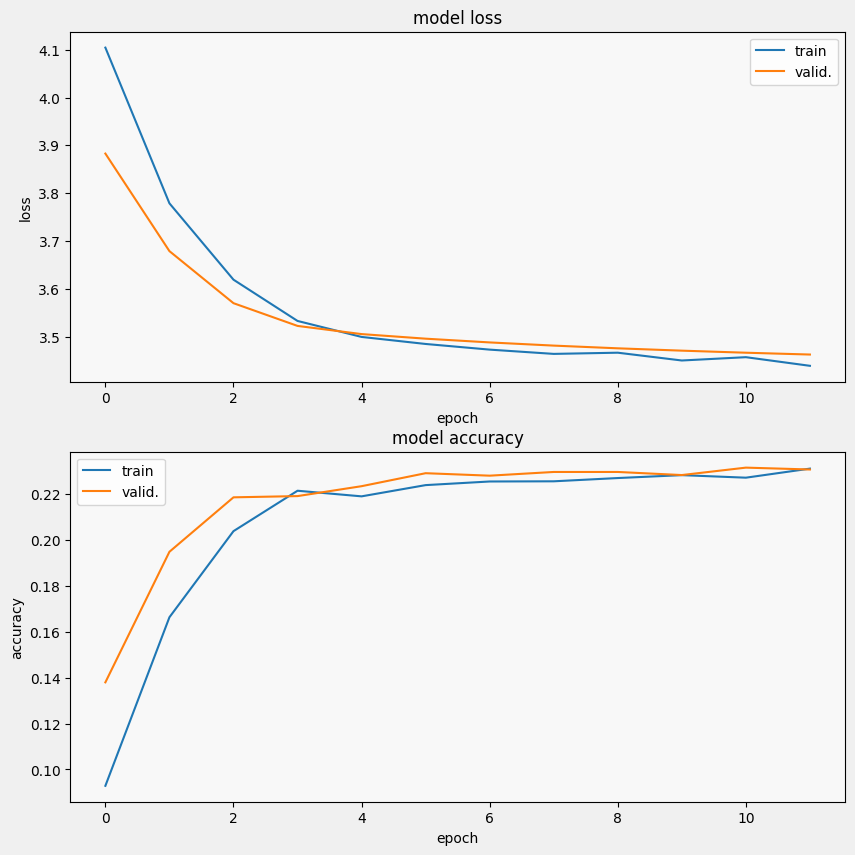

In [16]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

# Step 7: Evaluate Predictions #

Before making your final predictions on the test set, it's a good idea to evaluate your model's predictions on the validation set. This can help you diagnose problems in training or suggest ways your model could be improved. We'll look at two common ways of validation: plotting the **confusion matrix** and **visual validation**.

In [17]:

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

## Confusion Matrix ##

A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) shows the actual class of an image tabulated against its predicted class. It is one of the best tools you have for evaluating the performance of a classifier.

The following cell does some processing on the validation data and then creates the matrix with the `confusion_matrix` function included in [`scikit-learn`](https://scikit-learn.org/stable/index.html).

In [18]:
cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

I0000 00:00:1756218238.105017      74 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:5596867530805883097


E0000 00:00:1756218238.120475      74 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node sequential_1_1/dense_1_1/BiasAdd/ReadVariableOp.


I0000 00:00:1756218238.178687     894 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(7320526102892703545), session_name()


I0000 00:00:1756218244.206254     894 tpu_compile_op_common.cc:245] Compilation of 7320526102892703545 with session name  took 6.027518529s and succeeded


I0000 00:00:1756218244.208108     894 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(7320526102892703545), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_5596867530805883097", property.function_library_fingerprint = 4704291093772383465, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1756218244.208133     894 tpu_compilation_cache_interface.cc:542] After adding entry for key 7320526102892703545 with session_name  cache is 3 entries (36076208 bytes),  marked for eviction 0 entries (0 bytes).


      1/Unknown 8s 8s/step

      2/Unknown 8s 117ms/step

      3/Unknown 8s 119ms/step

      4/Unknown 8s 119ms/step

      5/Unknown 8s 119ms/step

      6/Unknown 8s 118ms/step

      7/Unknown 8s 116ms/step

      8/Unknown 8s 114ms/step

      9/Unknown 9s 115ms/step

     10/Unknown 9s 116ms/step

     11/Unknown 9s 117ms/step

     12/Unknown 9s 115ms/step

     13/Unknown 9s 115ms/step

     14/Unknown 9s 116ms/step

     15/Unknown 9s 116ms/step

     16/Unknown 9s 115ms/step

     17/Unknown 9s 117ms/step

     18/Unknown 10s 117ms/step

     19/Unknown 10s 117ms/step

     20/Unknown 10s 117ms/step

     21/Unknown 10s 116ms/step

     22/Unknown 10s 117ms/step

     23/Unknown 10s 117ms/step

     24/Unknown 10s 118ms/step

     25/Unknown 10s 118ms/step

     26/Unknown 11s 118ms/step

     27/Unknown 11s 118ms/step

     28/Unknown 11s 119ms/step

     29/Unknown 11s 118ms/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step


You might be familiar with metrics like [F1-score](https://en.wikipedia.org/wiki/F1_score) or [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall). This cell will compute these metrics and display them with a plot of the confusion matrix. (These metrics are defined in the Scikit-learn module `sklearn.metrics`; we've imported them in the helper script for you.)

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


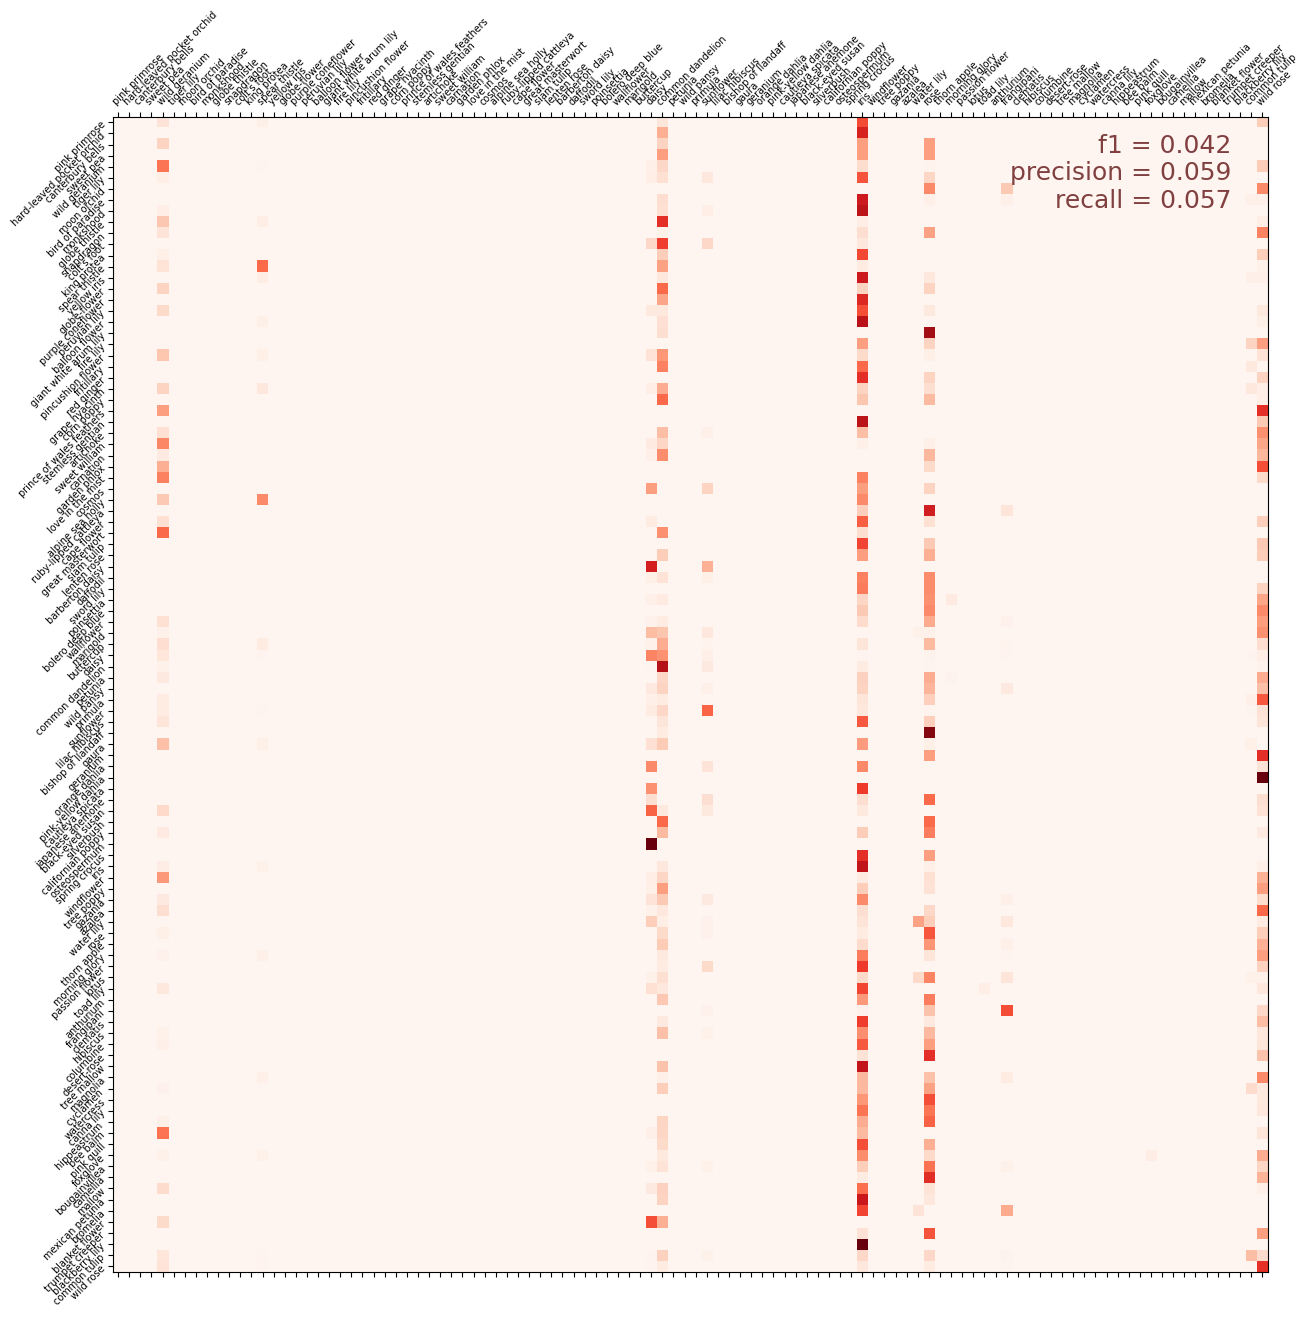

In [19]:
score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)

## Visual Validation ##

It can also be helpful to look at some examples from the validation set and see what class your model predicted. This can help reveal patterns in the kinds of images your model has trouble with.

This cell will set up the validation set to display 20 images at a time -- you can change this to display more or fewer, if you like.

In [20]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

And here is a set of flowers with their predicted species. Run the cell again to see another set.

I0000 00:00:1756218251.779333      74 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:11977009887187203739


I0000 00:00:1756218251.945291     848 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(4959364322751788259), session_name()


I0000 00:00:1756218261.326467     848 tpu_compile_op_common.cc:245] Compilation of 4959364322751788259 with session name  took 9.381132655s and succeeded
I0000 00:00:1756218261.327933     848 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(4959364322751788259), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_11977009887187203739", property.function_library_fingerprint = 17576801623902871454, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,512,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1756218261.327956     848 tpu_compilation_cache_interface.cc:542] After adding entry for key

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


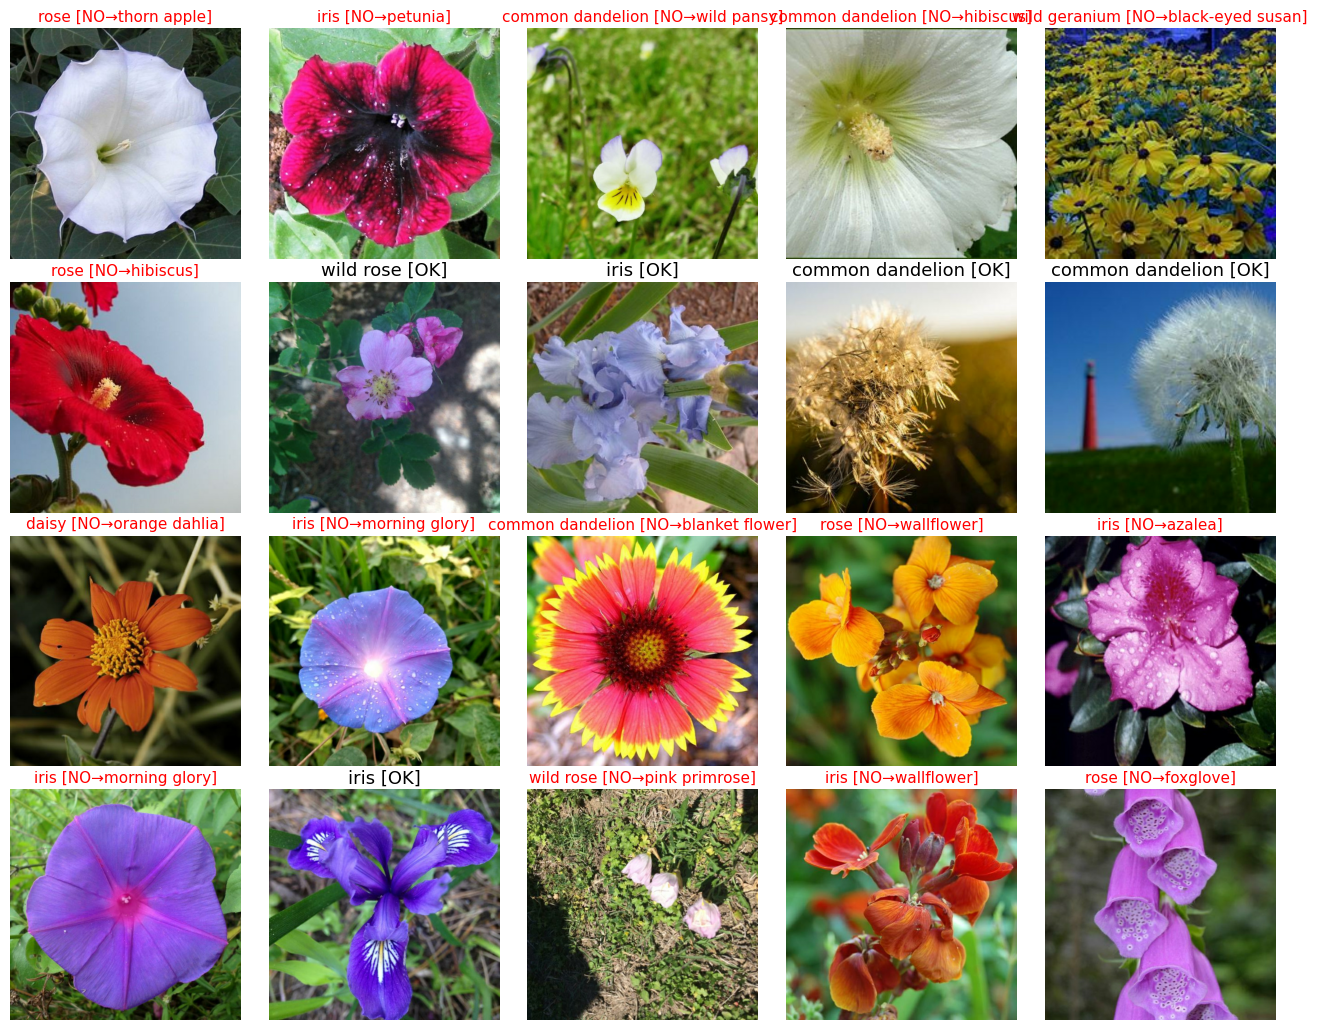

In [21]:
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

# Step 8: Make Test Predictions #

Once you're satisfied with everything, you're ready to make predictions on the test set.

In [22]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...


      1/Unknown 2s 2s/step

      2/Unknown 2s 99ms/step

      3/Unknown 2s 150ms/step

      4/Unknown 2s 151ms/step

      5/Unknown 2s 143ms/step

      6/Unknown 3s 140ms/step

      7/Unknown 3s 140ms/step

      8/Unknown 3s 143ms/step

      9/Unknown 3s 146ms/step

     10/Unknown 3s 144ms/step

     11/Unknown 3s 143ms/step

     12/Unknown 3s 145ms/step

     13/Unknown 4s 144ms/step

     14/Unknown 4s 145ms/step

     15/Unknown 4s 144ms/step

     16/Unknown 4s 143ms/step

     17/Unknown 4s 143ms/step

     18/Unknown 4s 143ms/step

     19/Unknown 4s 143ms/step

     20/Unknown 5s 143ms/step

     21/Unknown 5s 145ms/step

     22/Unknown 5s 146ms/step

     23/Unknown 5s 144ms/step

     24/Unknown 5s 144ms/step

     25/Unknown 5s 143ms/step

     26/Unknown 5s 145ms/step

     27/Unknown 6s 146ms/step

     28/Unknown 6s 145ms/step

     29/Unknown 6s 145ms/step

     30/Unknown 6s 146ms/step

     31/Unknown 6s 146ms/step

     32/Unknown 6s 146ms/step

     33/Unknown 6s 146ms/step

     34/Unknown 7s 146ms/step

     35/Unknown 7s 146ms/step

     36/Unknown 7s 147ms/step

     37/Unknown 7s 147ms/step

     38/Unknown 7s 147ms/step

     39/Unknown 7s 147ms/step

     40/Unknown 8s 149ms/step

     41/Unknown 8s 149ms/step

     42/Unknown 8s 148ms/step

     43/Unknown 8s 149ms/step

     44/Unknown 8s 149ms/step

     45/Unknown 8s 149ms/step

     46/Unknown 9s 149ms/step

     47/Unknown 9s 149ms/step

     48/Unknown 9s 150ms/step

     49/Unknown 9s 150ms/step

     50/Unknown 9s 149ms/step

     51/Unknown 9s 150ms/step

     52/Unknown 10s 152ms/step

     53/Unknown 10s 151ms/step

     54/Unknown 10s 151ms/step

     55/Unknown 10s 151ms/step

     56/Unknown 10s 150ms/step

     57/Unknown 10s 150ms/step

/usr/local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step


[ 49 103 103 ...  13  67  67]


We'll generate a file `submission.csv`. This file is what you'll submit to get your score on the leaderboard.

In [23]:
print('Generating submission.csv file...')

# Get image ids from test set and convert to unicode
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

# Look at the first few predictions
!head submission.csv

Generating submission.csv file...


id,label
0b9afbdf2,49
c37a6f3e9,103
00e4f514e,103
1c4736dea,4
252d840db,67
dfc9c6a23,103
53cfc6586,48
541c4d41e,73
59d1b6146,53


# Step 9: Make a submission #

If you haven't already, create your own editable copy of this notebook by clicking on the **Copy and Edit** button in the top right corner. Then, submit to the competition by following these steps:

1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.


---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/161321) to chat with other Learners.*